In [ ]:
# Bibliotecas para análise de dados e visualização
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Bibliotecas para deep learning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Módulo local para representação molecular
from representacao import Representacao

2025-07-17 10:46:35.421034: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 10:46:40.029842: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-17 10:46:40.036900: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-17 10:46:42.961613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# Configurações de hiperparâmetros para otimização
use_count_option = [False, True]
fp_size_option = [2048, 4096, 8192]
radius_option = [2, 3, 5]

# Análise de toxicidade intravenosa em ratos

In [ ]:
# Configurações do experimento
arquivo_classificado = "rat_vi_classificado.csv"
nome_dataset = arquivo_classificado.split("_classificado")[0]
exibir_plot = True  # Configurar como False para execução em lote

In [ ]:
# Carregamento dos dados classificados
df = pd.read_csv(arquivo_classificado)

# Exibição das primeiras linhas para verificação
display(df.head())

,smiles,cid,rat_vi,GHS_Category
0,Br.Br.N=C(N)SCCN,5940.0,85.0,3
1,Br.C=CCN(C1=NCCN1)c1c(Cl)cccc1Cl,134052.0,24.8,2
2,Br.CC(=O)SCc1cnc(C)c(O)c1CN,28546.0,405.0,4
3,Br.CC(=O)SCc1cnc(C)c(O)c1CSC(C)=O,51855.0,41.0,2
4,Br.CC(Cc1ccc(O)cc1)NCC(O)c1cc(O)cc(O)c1,5702161.0,65.0,3


In [ ]:
# Preparação das variáveis para classificação
print("--- Mapeando categorias GHS para softmax ---")
df["GHS_Category_softmax"] = df["GHS_Category"].astype(int) - 1
df

--- Mapeando categorias GHS para softmax ---


,smiles,cid,rat_vi,GHS_Category,GHS_Category_softmax
0,Br.Br.N=C(N)SCCN,5940.0,85.0,3,2
1,Br.C=CCN(C1=NCCN1)c1c(Cl)cccc1Cl,134052.0,24.8,2,1
2,Br.CC(=O)SCc1cnc(C)c(O)c1CN,28546.0,405.0,4,3
3,Br.CC(=O)SCc1cnc(C)c(O)c1CSC(C)=O,51855.0,41.0,2,1
4,Br.CC(Cc1ccc(O)cc1)NCC(O)c1cc(O)cc(O)c1,5702161.0,65.0,3,2
...,...,...,...,...,...
3051,c1ccc(C2CN3CCSC3=N2)cc1,26879.0,24.0,2,1
3052,c1ccc2c(C(CCN3CCOCC3)CCN3CCOCC3)cccc2c1,202647.0,26.0,2,1
3053,c1ccc2cc3c(ccc4ccccc43)cc2c1,5954.0,200.0,3,2
3054,c1ccncc1,1049.0,360.0,4,3


In [ ]:
# Definição dos rótulos para visualização
classes = [f"GHS-{i+1}" for i in range(df["GHS_Category_softmax"].nunique())]

In [ ]:
# Inicialização da lista para armazenar resultados
resultados = []

In [ ]:
# Loop de otimização de hiperparâmetros
for use_count in use_count_option:
    for fp_size in fp_size_option:
        for radius in radius_option:
            print(f"\nTestando: use_count={use_count}, fp_size={fp_size}, radius={radius}")

            try: 
                # Geração de fingerprints moleculares
                rep = Representacao(df)
                df_fp = rep.fingerprint(
                    col_smiles="smiles",
                    fingerprint="morgan",
                    radius=radius,
                    fp_size=fp_size,
                    use_count=use_count
                )

                # Remoção de moléculas que não geraram fingerprint
                df_fp = df_fp.dropna(subset=["Features"])

                # Preparação das variáveis de entrada e saída
                X = np.stack(df_fp["Features"].values)
                y = df_fp["GHS_Category_softmax"].values

                # Divisão estratificada em conjuntos de treino e teste
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, stratify=y, test_size=0.2, random_state=42
                )

                # Construção da arquitetura da rede neural
                model = Sequential([
                    Dense(256, activation="relu", input_shape=(X.shape[1],)),
                    Dropout(0.3),
                    Dense(128, activation="relu"),
                    Dropout(0.3),
                    Dense(len(np.unique(y)), activation="softmax")
                ])         
                
                # Compilação do modelo
                model.compile(
                    optimizer="adam",
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"]
                )

                # Configuração de early stopping para evitar overfitting
                early_stop = EarlyStopping(
                    monitor="val_loss", patience=5, restore_best_weights=True
                )

                # Treinamento do modelo
                model.fit(
                    X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=0
                )
                
                # Avaliação do modelo
                y_pred_prob = model.predict(X_test)
                y_pred_classes = np.argmax(y_pred_prob, axis=1)

                acc = accuracy_score(y_test, y_pred_classes)
                print(f"Acurácia: {acc}")

                # Armazenamento dos resultados para análise posterior
                resultados.append({
                    "use_count": use_count,
                    "fp_size": fp_size,
                    "radius": radius,
                    "accuracy": acc,
                    "y_test": y_test,
                    "y_pred": y_pred_classes
                })

            except Exception as e:
                print(f"Erro em: use_count={use_count}, fp_size={fp_size}, radius={radius}")
                print(e)


Testando: use_count=False, fpSize=2048, radius=2


[10:53:32] WARNING: not removing hydrogen atom without neighbors
[10:53:32] WARNING: not removing hydrogen atom without neighbors
[10:53:32] WARNING: not removing hydrogen atom without neighbors
[10:53:32] WARNING: not removing hydrogen atom without neighbors
[10:53:32] WARNING: not removing hydrogen atom without neighbors
[10:53:32] WARNING: not removing hydrogen atom without neighbors
[10:53:32] WARNING: not removing hydrogen atom without neighbors
[10:53:32] Unusual charge on atom 4 number of radical electrons set to zero
[10:53:32] WARNING: not removing hydrogen atom without neighbors
[10:53:32] WARNING: not removing hydrogen atom without neighbors
[10:53:33] WARNING: not removing hydrogen atom without neighbors
2025-07-17 10:53:35.823664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-07-17 10:53:35.825499: W tensor

20/20 [==============================] - 0s 4ms/step
Acurácia: 0.6013071895424836

Testando: use_count=False, fpSize=2048, radius=3


[10:53:50] WARNING: not removing hydrogen atom without neighbors
[10:53:50] WARNING: not removing hydrogen atom without neighbors
[10:53:45] WARNING: not removing hydrogen atom without neighbors
[10:53:45] WARNING: not removing hydrogen atom without neighbors
[10:53:45] WARNING: not removing hydrogen atom without neighbors
[10:53:45] WARNING: not removing hydrogen atom without neighbors
[10:53:45] WARNING: not removing hydrogen atom without neighbors
[10:53:45] Unusual charge on atom 4 number of radical electrons set to zero
[10:53:45] WARNING: not removing hydrogen atom without neighbors
[10:53:45] WARNING: not removing hydrogen atom without neighbors
[10:53:45] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 5s 271ms/step
Acurácia: 0.6094771241830066

Testando: use_count=False, fpSize=2048, radius=5


[10:54:01] WARNING: not removing hydrogen atom without neighbors
[10:54:01] WARNING: not removing hydrogen atom without neighbors
[10:54:01] WARNING: not removing hydrogen atom without neighbors
[10:54:01] WARNING: not removing hydrogen atom without neighbors
[10:54:01] WARNING: not removing hydrogen atom without neighbors
[10:54:01] WARNING: not removing hydrogen atom without neighbors
[10:54:01] WARNING: not removing hydrogen atom without neighbors
[10:54:01] Unusual charge on atom 4 number of radical electrons set to zero
[10:54:01] WARNING: not removing hydrogen atom without neighbors
[10:54:01] WARNING: not removing hydrogen atom without neighbors
[10:54:01] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 5ms/step
Acurácia: 0.5800653594771242

Testando: use_count=False, fpSize=4096, radius=2


[10:54:12] WARNING: not removing hydrogen atom without neighbors
[10:54:12] WARNING: not removing hydrogen atom without neighbors
[10:54:12] WARNING: not removing hydrogen atom without neighbors
[10:54:12] WARNING: not removing hydrogen atom without neighbors
[10:54:12] WARNING: not removing hydrogen atom without neighbors
[10:54:12] WARNING: not removing hydrogen atom without neighbors
[10:54:12] WARNING: not removing hydrogen atom without neighbors
[10:54:12] Unusual charge on atom 4 number of radical electrons set to zero
[10:54:12] WARNING: not removing hydrogen atom without neighbors
[10:54:12] WARNING: not removing hydrogen atom without neighbors
[10:54:13] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 6ms/step
Acurácia: 0.6045751633986928

Testando: use_count=False, fpSize=4096, radius=3


[10:54:19] WARNING: not removing hydrogen atom without neighbors
[10:54:19] WARNING: not removing hydrogen atom without neighbors
[10:54:19] WARNING: not removing hydrogen atom without neighbors
[10:54:19] WARNING: not removing hydrogen atom without neighbors
[10:54:19] WARNING: not removing hydrogen atom without neighbors
[10:54:19] WARNING: not removing hydrogen atom without neighbors
[10:54:19] WARNING: not removing hydrogen atom without neighbors
[10:54:20] Unusual charge on atom 4 number of radical electrons set to zero
[10:54:20] WARNING: not removing hydrogen atom without neighbors
[10:54:20] WARNING: not removing hydrogen atom without neighbors
[10:54:20] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 5ms/step
Acurácia: 0.6013071895424836

Testando: use_count=False, fpSize=4096, radius=5


[10:54:32] WARNING: not removing hydrogen atom without neighbors
[10:54:32] WARNING: not removing hydrogen atom without neighbors
[10:54:32] WARNING: not removing hydrogen atom without neighbors
[10:54:32] WARNING: not removing hydrogen atom without neighbors
[10:54:32] WARNING: not removing hydrogen atom without neighbors
[10:54:32] WARNING: not removing hydrogen atom without neighbors
[10:54:32] WARNING: not removing hydrogen atom without neighbors
[10:54:32] Unusual charge on atom 4 number of radical electrons set to zero
[10:54:32] WARNING: not removing hydrogen atom without neighbors
[10:54:32] WARNING: not removing hydrogen atom without neighbors
[10:54:32] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 7ms/step
Acurácia: 0.6029411764705882

Testando: use_count=False, fpSize=8192, radius=2


[10:54:45] WARNING: not removing hydrogen atom without neighbors
[10:54:45] WARNING: not removing hydrogen atom without neighbors
[10:54:45] WARNING: not removing hydrogen atom without neighbors
[10:54:45] WARNING: not removing hydrogen atom without neighbors
[10:54:45] WARNING: not removing hydrogen atom without neighbors
[10:54:45] WARNING: not removing hydrogen atom without neighbors
[10:54:45] WARNING: not removing hydrogen atom without neighbors
[10:54:45] Unusual charge on atom 4 number of radical electrons set to zero
[10:54:45] WARNING: not removing hydrogen atom without neighbors
[10:54:45] WARNING: not removing hydrogen atom without neighbors
[10:54:45] WARNING: not removing hydrogen atom without neighbors
2025-07-17 10:54:46.543785: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16015360 exceeds 10% of free system memory.


20/20 [==============================] - 0s 7ms/step
Acurácia: 0.6062091503267973

Testando: use_count=False, fpSize=8192, radius=3


[10:55:12] WARNING: not removing hydrogen atom without neighbors
[10:55:12] WARNING: not removing hydrogen atom without neighbors
[10:55:12] WARNING: not removing hydrogen atom without neighbors
[10:55:12] WARNING: not removing hydrogen atom without neighbors
[10:55:12] WARNING: not removing hydrogen atom without neighbors
[10:55:12] WARNING: not removing hydrogen atom without neighbors
[10:55:12] WARNING: not removing hydrogen atom without neighbors
[10:55:12] Unusual charge on atom 4 number of radical electrons set to zero
[10:55:12] WARNING: not removing hydrogen atom without neighbors
[10:55:12] WARNING: not removing hydrogen atom without neighbors
[10:55:12] WARNING: not removing hydrogen atom without neighbors
2025-07-17 10:55:14.022348: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16015360 exceeds 10% of free system memory.


20/20 [==============================] - 0s 8ms/step
Acurácia: 0.6078431372549019

Testando: use_count=False, fpSize=8192, radius=5


[10:55:27] WARNING: not removing hydrogen atom without neighbors
[10:55:27] WARNING: not removing hydrogen atom without neighbors
[10:55:27] WARNING: not removing hydrogen atom without neighbors
[10:55:27] WARNING: not removing hydrogen atom without neighbors
[10:55:27] WARNING: not removing hydrogen atom without neighbors
[10:55:27] WARNING: not removing hydrogen atom without neighbors
[10:55:27] WARNING: not removing hydrogen atom without neighbors
[10:55:27] Unusual charge on atom 4 number of radical electrons set to zero
[10:55:27] WARNING: not removing hydrogen atom without neighbors
[10:55:27] WARNING: not removing hydrogen atom without neighbors
[10:55:27] WARNING: not removing hydrogen atom without neighbors
2025-07-17 10:55:29.892228: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16015360 exceeds 10% of free system memory.


20/20 [==============================] - 0s 7ms/step
Acurácia: 0.6045751633986928

Testando: use_count=True, fpSize=2048, radius=2


[10:55:54] WARNING: not removing hydrogen atom without neighbors
[10:55:54] WARNING: not removing hydrogen atom without neighbors
[10:55:54] WARNING: not removing hydrogen atom without neighbors
[10:55:54] WARNING: not removing hydrogen atom without neighbors
[10:55:54] WARNING: not removing hydrogen atom without neighbors
[10:55:54] WARNING: not removing hydrogen atom without neighbors
[10:55:54] WARNING: not removing hydrogen atom without neighbors
[10:55:54] Unusual charge on atom 4 number of radical electrons set to zero
[10:55:55] WARNING: not removing hydrogen atom without neighbors
[10:55:55] WARNING: not removing hydrogen atom without neighbors
[10:55:55] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 7ms/step
Acurácia: 0.5996732026143791

Testando: use_count=True, fpSize=2048, radius=3


[10:56:04] WARNING: not removing hydrogen atom without neighbors
[10:56:04] WARNING: not removing hydrogen atom without neighbors
[10:56:04] WARNING: not removing hydrogen atom without neighbors
[10:56:04] WARNING: not removing hydrogen atom without neighbors
[10:56:04] WARNING: not removing hydrogen atom without neighbors
[10:56:04] WARNING: not removing hydrogen atom without neighbors
[10:56:04] WARNING: not removing hydrogen atom without neighbors
[10:56:04] Unusual charge on atom 4 number of radical electrons set to zero
[10:56:04] WARNING: not removing hydrogen atom without neighbors
[10:56:04] WARNING: not removing hydrogen atom without neighbors
[10:56:05] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 5ms/step
Acurácia: 0.5522875816993464

Testando: use_count=True, fpSize=2048, radius=5


[10:56:13] WARNING: not removing hydrogen atom without neighbors
[10:56:13] WARNING: not removing hydrogen atom without neighbors
[10:56:13] WARNING: not removing hydrogen atom without neighbors
[10:56:13] WARNING: not removing hydrogen atom without neighbors
[10:56:13] WARNING: not removing hydrogen atom without neighbors
[10:56:13] WARNING: not removing hydrogen atom without neighbors
[10:56:13] WARNING: not removing hydrogen atom without neighbors
[10:56:13] Unusual charge on atom 4 number of radical electrons set to zero
[10:56:13] WARNING: not removing hydrogen atom without neighbors
[10:56:13] WARNING: not removing hydrogen atom without neighbors
[10:56:13] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 5ms/step
Acurácia: 0.5816993464052288

Testando: use_count=True, fpSize=4096, radius=2


[10:56:22] WARNING: not removing hydrogen atom without neighbors
[10:56:22] WARNING: not removing hydrogen atom without neighbors
[10:56:23] WARNING: not removing hydrogen atom without neighbors
[10:56:23] WARNING: not removing hydrogen atom without neighbors
[10:56:23] WARNING: not removing hydrogen atom without neighbors
[10:56:23] WARNING: not removing hydrogen atom without neighbors
[10:56:23] WARNING: not removing hydrogen atom without neighbors
[10:56:23] Unusual charge on atom 4 number of radical electrons set to zero
[10:56:23] WARNING: not removing hydrogen atom without neighbors
[10:56:23] WARNING: not removing hydrogen atom without neighbors
[10:56:23] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 5ms/step
Acurácia: 0.5833333333333334

Testando: use_count=True, fpSize=4096, radius=3


[10:56:35] WARNING: not removing hydrogen atom without neighbors
[10:56:35] WARNING: not removing hydrogen atom without neighbors
[10:56:35] WARNING: not removing hydrogen atom without neighbors
[10:56:35] WARNING: not removing hydrogen atom without neighbors
[10:56:35] WARNING: not removing hydrogen atom without neighbors
[10:56:35] WARNING: not removing hydrogen atom without neighbors
[10:56:35] WARNING: not removing hydrogen atom without neighbors
[10:56:35] Unusual charge on atom 4 number of radical electrons set to zero
[10:56:35] WARNING: not removing hydrogen atom without neighbors
[10:56:35] WARNING: not removing hydrogen atom without neighbors
[10:56:35] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 5ms/step
Acurácia: 0.6127450980392157

Testando: use_count=True, fpSize=4096, radius=5


[10:56:48] WARNING: not removing hydrogen atom without neighbors
[10:56:48] WARNING: not removing hydrogen atom without neighbors
[10:56:48] WARNING: not removing hydrogen atom without neighbors
[10:56:48] WARNING: not removing hydrogen atom without neighbors
[10:56:48] WARNING: not removing hydrogen atom without neighbors
[10:56:48] WARNING: not removing hydrogen atom without neighbors
[10:56:48] WARNING: not removing hydrogen atom without neighbors
[10:56:48] Unusual charge on atom 4 number of radical electrons set to zero
[10:56:48] WARNING: not removing hydrogen atom without neighbors
[10:56:48] WARNING: not removing hydrogen atom without neighbors
[10:56:48] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 6ms/step
Acurácia: 0.5866013071895425

Testando: use_count=True, fpSize=8192, radius=2


[10:57:01] WARNING: not removing hydrogen atom without neighbors
[10:57:01] WARNING: not removing hydrogen atom without neighbors
[10:57:01] WARNING: not removing hydrogen atom without neighbors
[10:57:01] WARNING: not removing hydrogen atom without neighbors
[10:57:01] WARNING: not removing hydrogen atom without neighbors
[10:57:01] WARNING: not removing hydrogen atom without neighbors
[10:57:01] WARNING: not removing hydrogen atom without neighbors
[10:57:01] Unusual charge on atom 4 number of radical electrons set to zero
[10:57:01] WARNING: not removing hydrogen atom without neighbors
[10:57:01] WARNING: not removing hydrogen atom without neighbors
[10:57:01] WARNING: not removing hydrogen atom without neighbors
2025-07-17 10:57:03.317535: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16015360 exceeds 10% of free system memory.


20/20 [==============================] - 0s 8ms/step
Acurácia: 0.6160130718954249

Testando: use_count=True, fpSize=8192, radius=3


[10:57:22] WARNING: not removing hydrogen atom without neighbors
[10:57:22] WARNING: not removing hydrogen atom without neighbors
[10:57:23] WARNING: not removing hydrogen atom without neighbors
[10:57:23] WARNING: not removing hydrogen atom without neighbors
[10:57:23] WARNING: not removing hydrogen atom without neighbors
[10:57:23] WARNING: not removing hydrogen atom without neighbors
[10:57:23] WARNING: not removing hydrogen atom without neighbors
[10:57:23] Unusual charge on atom 4 number of radical electrons set to zero
[10:57:23] WARNING: not removing hydrogen atom without neighbors
[10:57:23] WARNING: not removing hydrogen atom without neighbors
[10:57:23] WARNING: not removing hydrogen atom without neighbors


20/20 [==============================] - 0s 7ms/step
Acurácia: 0.5931372549019608

Testando: use_count=True, fpSize=8192, radius=5


[10:57:44] WARNING: not removing hydrogen atom without neighbors
[10:57:44] WARNING: not removing hydrogen atom without neighbors
[10:57:44] WARNING: not removing hydrogen atom without neighbors
[10:57:44] WARNING: not removing hydrogen atom without neighbors
[10:57:44] WARNING: not removing hydrogen atom without neighbors
[10:57:44] WARNING: not removing hydrogen atom without neighbors
[10:57:44] WARNING: not removing hydrogen atom without neighbors
[10:57:45] Unusual charge on atom 4 number of radical electrons set to zero
[10:57:45] WARNING: not removing hydrogen atom without neighbors
[10:57:45] WARNING: not removing hydrogen atom without neighbors
[10:57:45] WARNING: not removing hydrogen atom without neighbors
2025-07-17 10:57:46.172533: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16015360 exceeds 10% of free system memory.


20/20 [==============================] - 0s 7ms/step
Acurácia: 0.5964052287581699


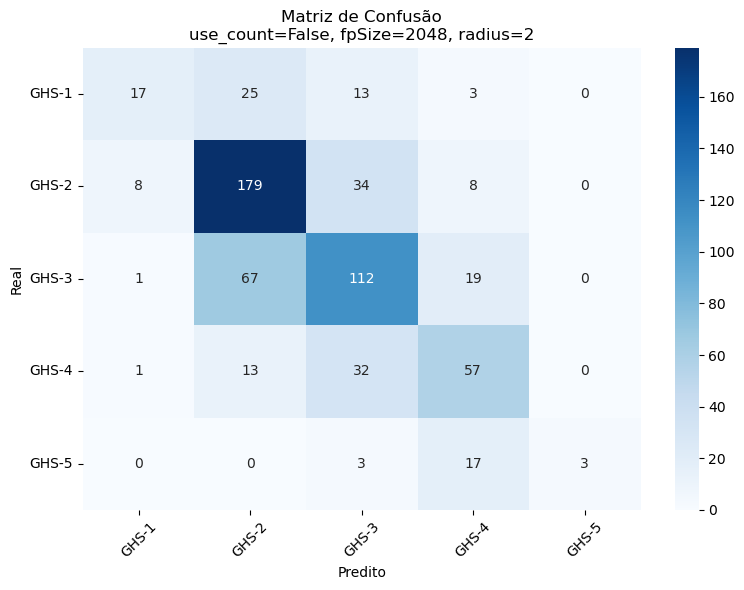

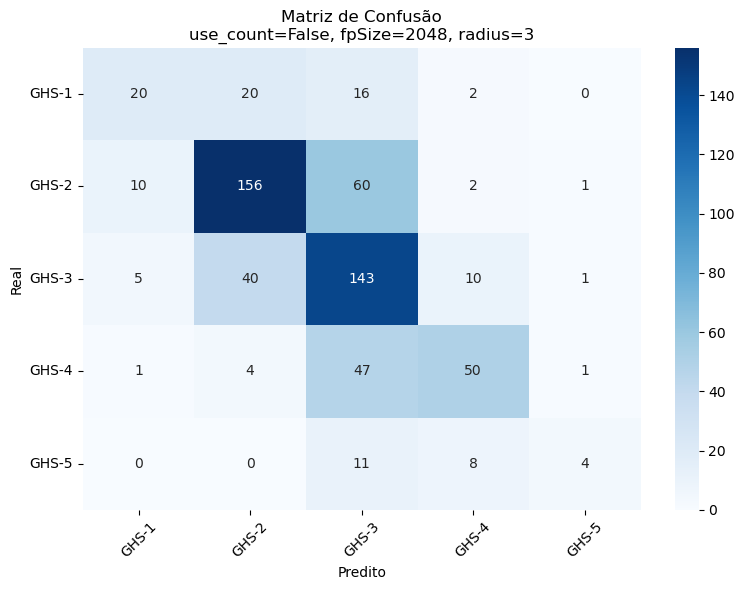

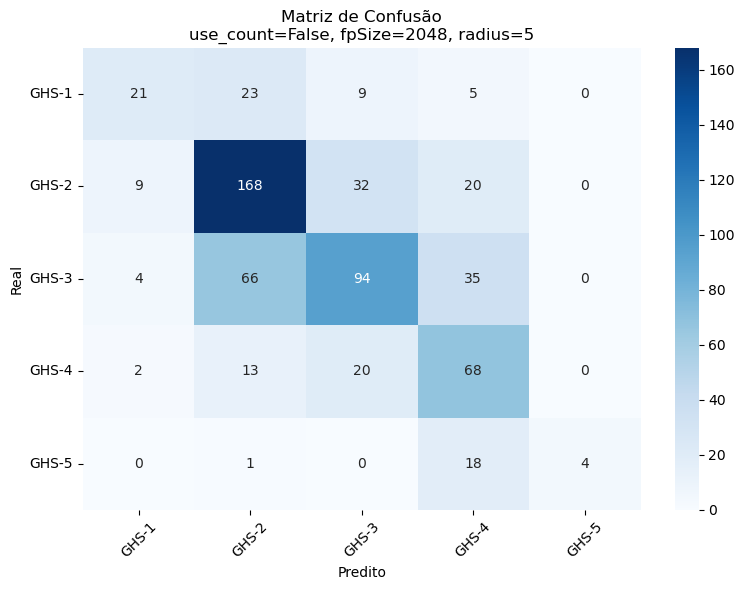

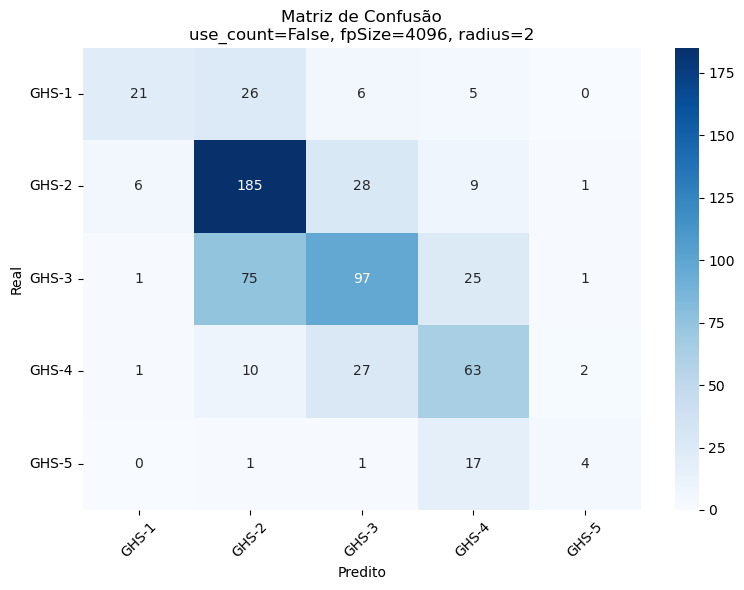

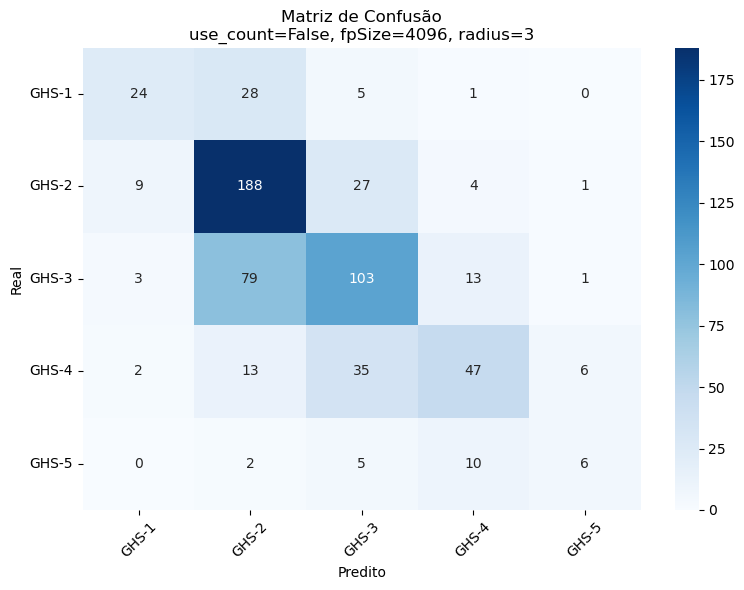

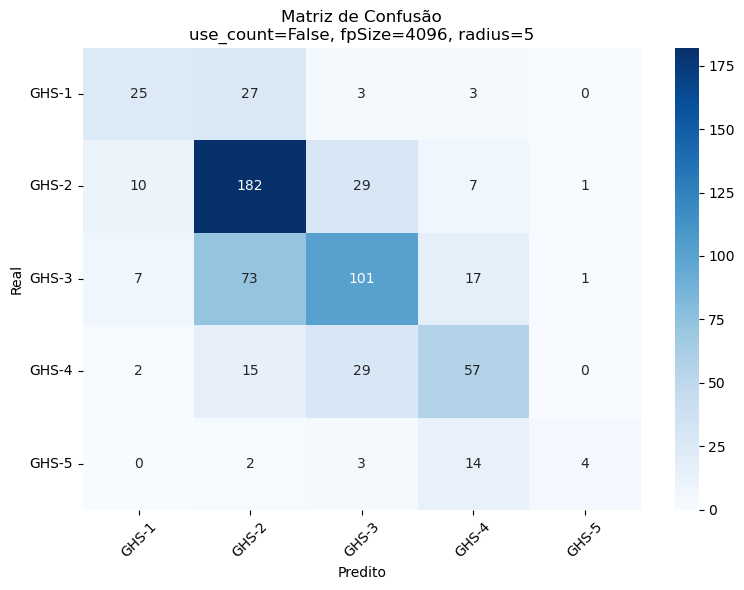

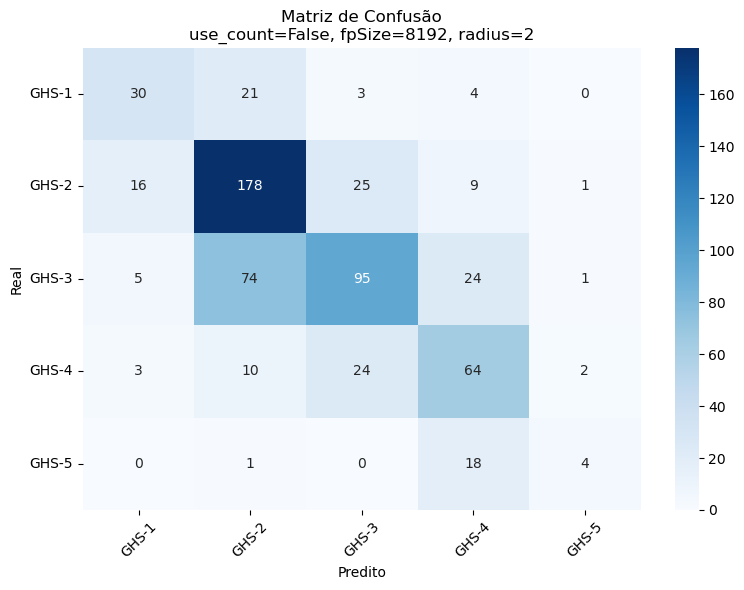

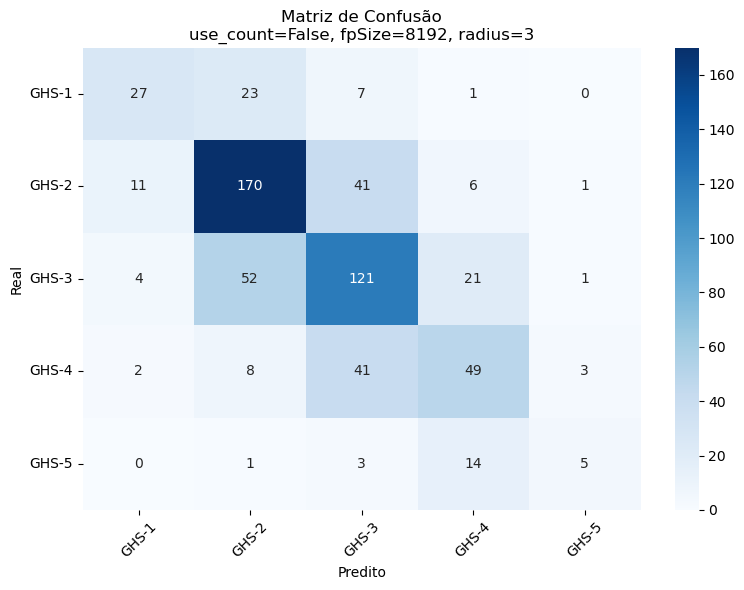

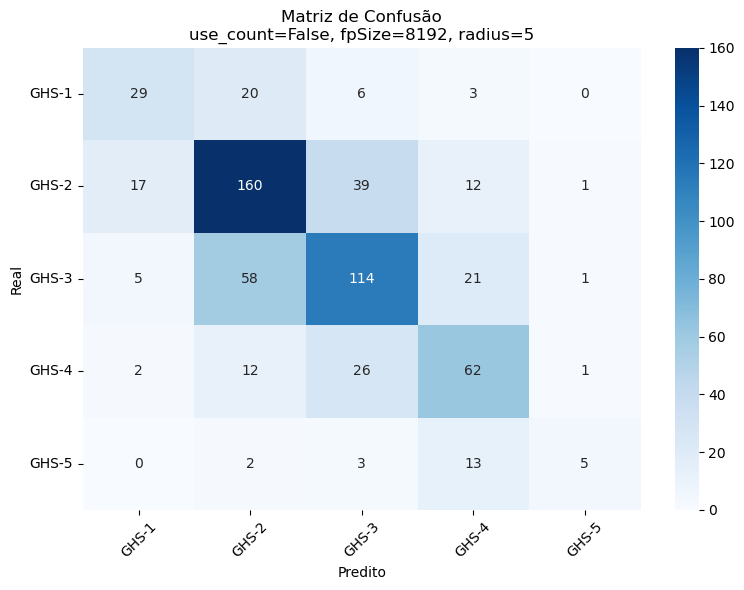

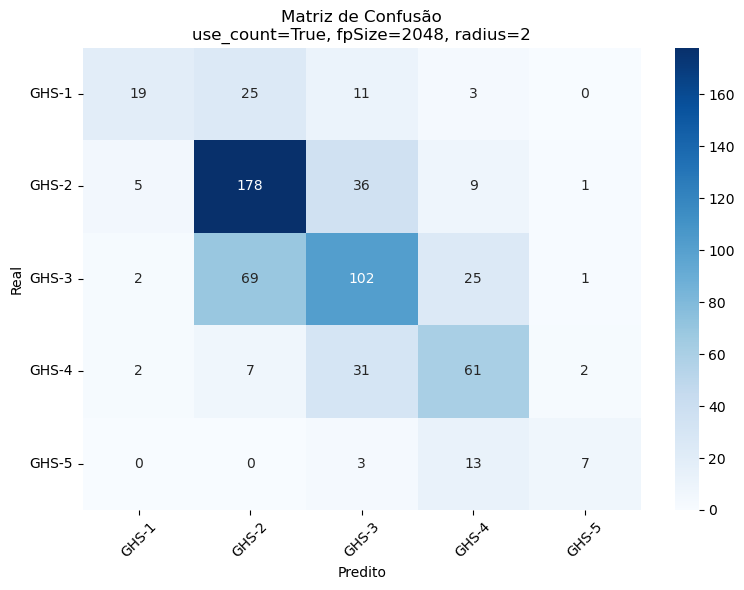

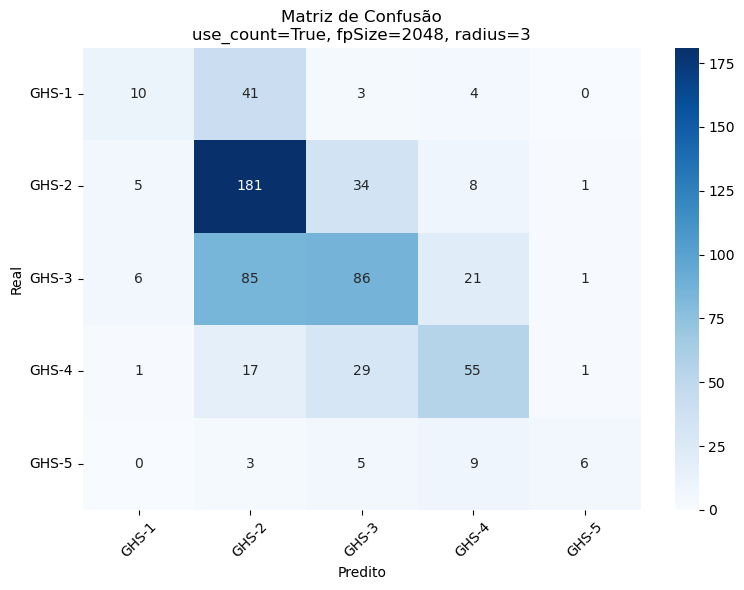

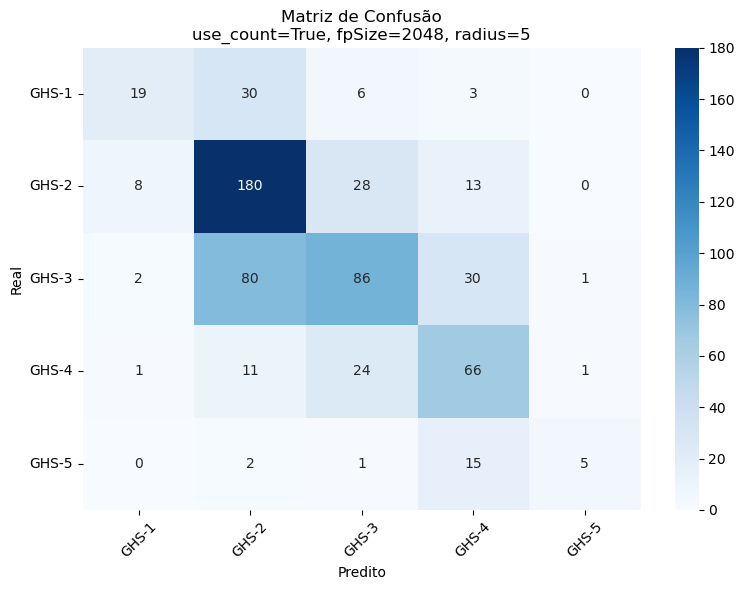

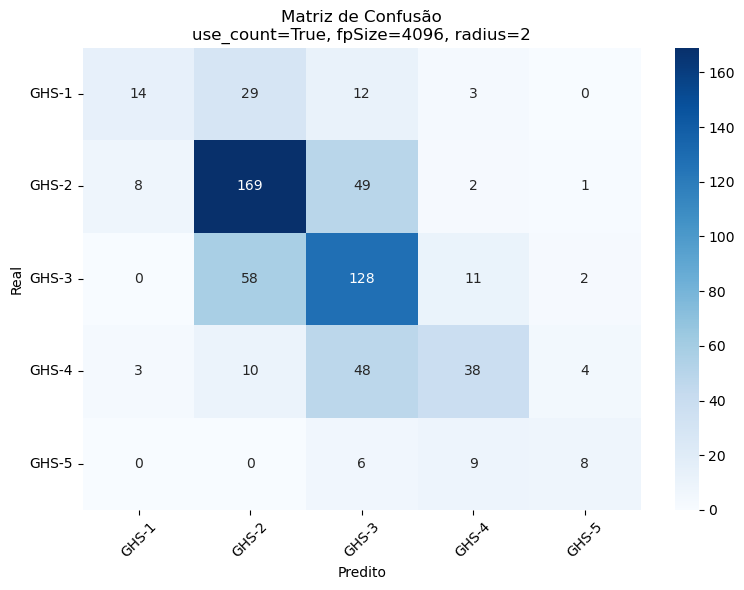

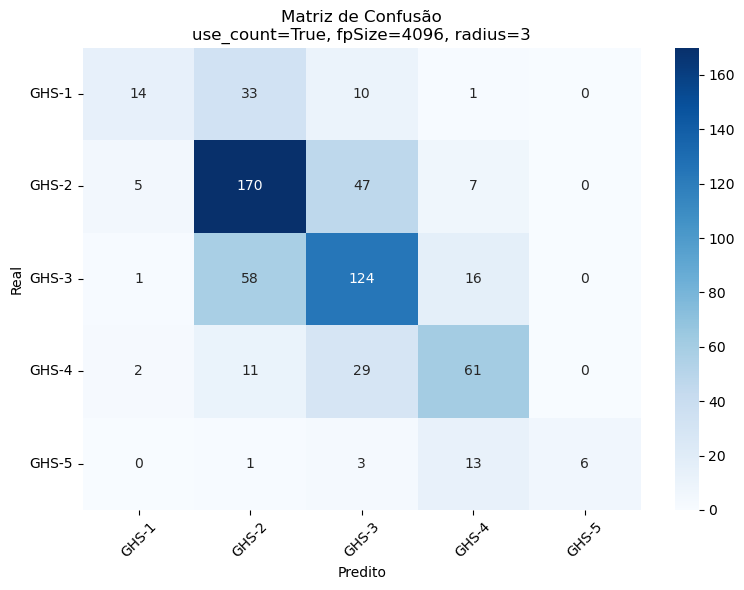

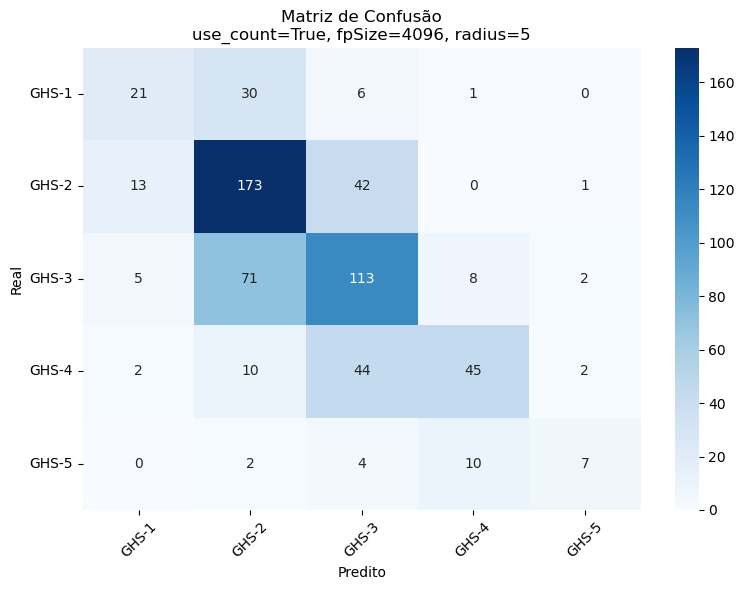

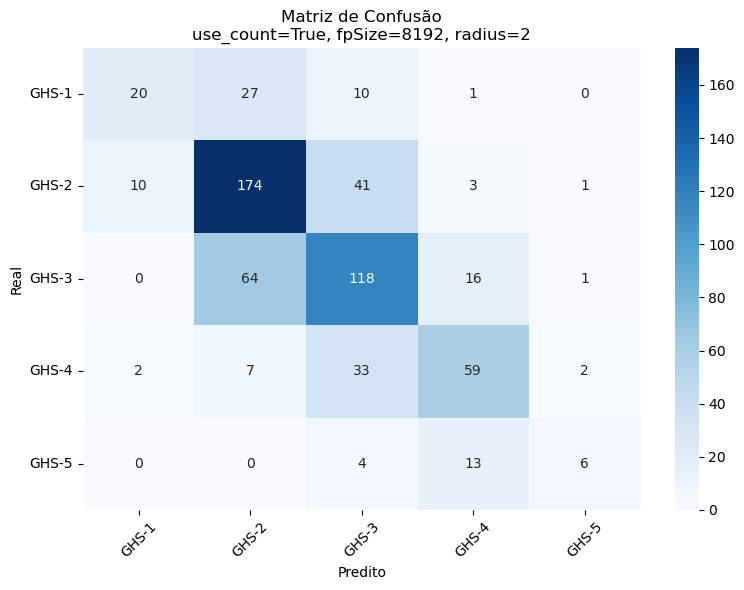

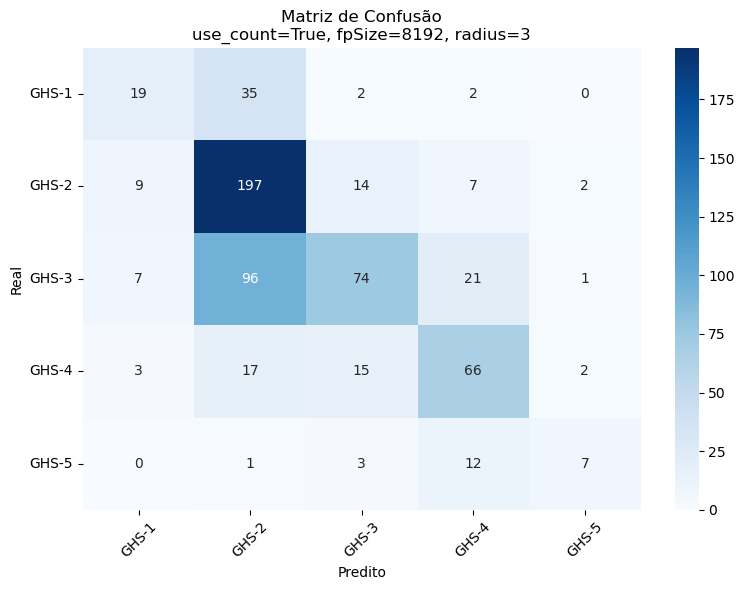

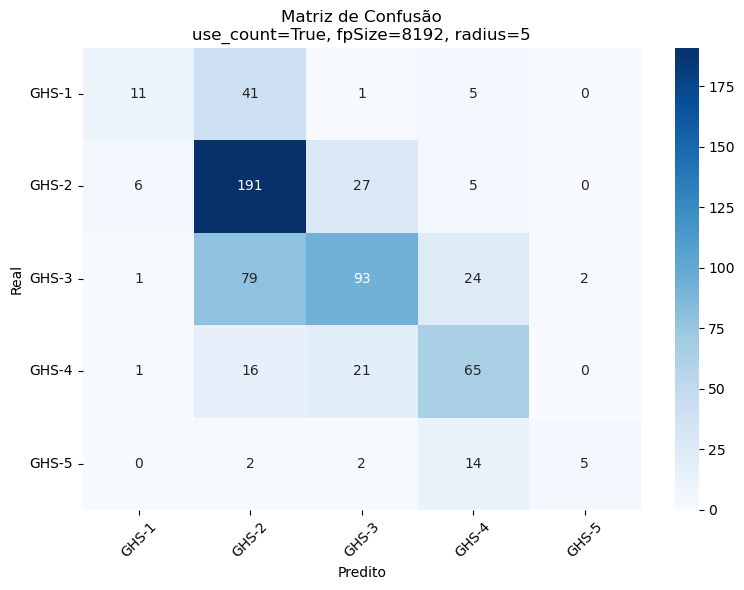

In [ ]:
import os

# Geração e salvamento das matrizes de confusão
for r in resultados:
    try:
        use_count = r["use_count"]
        fp_size = r["fp_size"]
        radius = r["radius"]
        y_true = r["y_test"]
        y_pred = r["y_pred"]

        # Criação do diretório de saída
        folder_path = os.path.join("Plots", nome_dataset)
        os.makedirs(folder_path, exist_ok=True)

        # Definição do nome do arquivo
        file_name = f"confusion_uc-{use_count}_fp-{fp_size}_r-{radius}.png"
        file_path = os.path.join(folder_path, file_name)

        # Geração da matriz de confusão
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes
        )
        plt.title(f"Matriz de Confusão\nuse_count={use_count}, fp_size={fp_size}, radius={radius}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(file_path)
        
        if exibir_plot:
            plt.show()
        else:
            plt.close()

    except Exception as e:
        print(f"Erro ao salvar o plot da combinação: uc={use_count}, fp={fp_size}, r={radius}")
        print(e)

In [ ]:
# Análise final dos resultados
if resultados:
    resultados_df = pd.DataFrame(resultados).drop(columns=["y_test", "y_pred"])
    print("\nRanking de combinações por acurácia:")
    print(resultados_df.sort_values(by='accuracy', ascending=False).to_string())
else:
    print("\nNenhum resultado foi gerado.")


Ranking de combinações por acurácia:
    use_count  fpSize  radius  accuracy
15       True    8192       2  0.616013
13       True    4096       3  0.612745
1       False    2048       3  0.609477
7       False    8192       3  0.607843
6       False    8192       2  0.606209
3       False    4096       2  0.604575
8       False    8192       5  0.604575
5       False    4096       5  0.602941
0       False    2048       2  0.601307
4       False    4096       3  0.601307
9        True    2048       2  0.599673
17       True    8192       5  0.596405
16       True    8192       3  0.593137
14       True    4096       5  0.586601
12       True    4096       2  0.583333
11       True    2048       5  0.581699
2       False    2048       5  0.580065
10       True    2048       3  0.552288


In [ ]:
# Salvamento dos resultados quantitativos
resultados_dir = os.path.join("Resultados", nome_dataset)
os.makedirs(resultados_dir, exist_ok=True)

# Definição do caminho do arquivo de saída
csv_path = os.path.join(resultados_dir, "resultados.csv")

# Salvamento do DataFrame com métricas de performance
resultados_df.to_csv(csv_path, index=False)

# Análise de toxicidade oral em ratos

--- Mapeando categorias GHS para softmax ---

Testando: use_count=False, fpSize=2048, radius=2


[11:14:07] WARNING: not removing hydrogen atom without neighbors
[11:14:07] WARNING: not removing hydrogen atom without neighbors
[11:14:07] WARNING: not removing hydrogen atom without neighbors
[11:14:12] WARNING: not removing hydrogen atom without neighbors
[11:14:12] WARNING: not removing hydrogen atom without neighbors
[11:14:13] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:14:08] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:14:13] WARNING: not removing hydrogen atom without neighbors
[11:14:13] WARNING: not removing hydrogen atom without neighbors
[11:14:13] Unusual charge on atom 53 number of radical electrons set to zero
[11:14:14] Unusual charge on atom 9 number of radical electrons set to zero
[11:14:14] WARNING: not removing hydrogen atom without neighbors
[11:14:14] Unusual charge on atom 4 number of radical electrons set to zero
[11:14:14] WARNING: not removing hydrogen atom without neighbors
[11:14:14] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 4ms/step
Acurácia: 0.54129724685021

Testando: use_count=False, fpSize=2048, radius=3


[11:14:49] WARNING: not removing hydrogen atom without neighbors
[11:14:49] WARNING: not removing hydrogen atom without neighbors
[11:14:49] WARNING: not removing hydrogen atom without neighbors
[11:14:49] WARNING: not removing hydrogen atom without neighbors
[11:14:49] WARNING: not removing hydrogen atom without neighbors
[11:14:50] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:14:50] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:14:51] WARNING: not removing hydrogen atom without neighbors
[11:14:51] WARNING: not removing hydrogen atom without neighbors
[11:14:51] Unusual charge on atom 53 number of radical electrons set to zero
[11:14:52] Unusual charge on atom 9 number of radical electrons set to zero
[11:14:52] WARNING: not removing hydrogen atom without neighbors
[11:14:52] Unusual charge on atom 4 number of radical electrons set to zero
[11:14:52] WARNING: not removing hydrogen atom without neighbors
[11:14:52] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 1s 7ms/step
Acurácia: 0.5333644423705086

Testando: use_count=False, fpSize=2048, radius=5


[11:15:26] WARNING: not removing hydrogen atom without neighbors
[11:15:26] WARNING: not removing hydrogen atom without neighbors
[11:15:26] WARNING: not removing hydrogen atom without neighbors
[11:15:34] WARNING: not removing hydrogen atom without neighbors
[11:15:34] WARNING: not removing hydrogen atom without neighbors
[11:15:34] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:15:35] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:15:36] WARNING: not removing hydrogen atom without neighbors
[11:15:36] WARNING: not removing hydrogen atom without neighbors
[11:15:36] Unusual charge on atom 53 number of radical electrons set to zero
[11:15:37] Unusual charge on atom 9 number of radical electrons set to zero
[11:15:37] WARNING: not removing hydrogen atom without neighbors
[11:15:37] Unusual charge on atom 4 number of radical electrons set to zero
[11:15:37] WARNING: not removing hydrogen atom without neighbors
[11:15:37] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 4ms/step
Acurácia: 0.5492300513299113

Testando: use_count=False, fpSize=4096, radius=2


[11:16:07] WARNING: not removing hydrogen atom without neighbors
[11:16:07] WARNING: not removing hydrogen atom without neighbors
[11:16:07] WARNING: not removing hydrogen atom without neighbors
[11:16:07] WARNING: not removing hydrogen atom without neighbors
[11:16:07] WARNING: not removing hydrogen atom without neighbors
[11:16:07] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:16:07] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:16:08] WARNING: not removing hydrogen atom without neighbors
[11:16:08] WARNING: not removing hydrogen atom without neighbors
[11:16:08] Unusual charge on atom 53 number of radical electrons set to zero
[11:16:08] Unusual charge on atom 9 number of radical electrons set to zero
[11:16:08] WARNING: not removing hydrogen atom without neighbors
[11:16:08] Unusual charge on atom 4 number of radical electrons set to zero
[11:16:08] WARNING: not removing hydrogen atom without neighbors
[11:16:08] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 4ms/step
Acurácia: 0.5478301446570228

Testando: use_count=False, fpSize=4096, radius=3


[11:16:36] WARNING: not removing hydrogen atom without neighbors
[11:16:36] WARNING: not removing hydrogen atom without neighbors
[11:16:36] WARNING: not removing hydrogen atom without neighbors
[11:16:36] WARNING: not removing hydrogen atom without neighbors
[11:16:36] WARNING: not removing hydrogen atom without neighbors
[11:16:36] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:16:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:16:36] WARNING: not removing hydrogen atom without neighbors
[11:16:36] WARNING: not removing hydrogen atom without neighbors
[11:16:37] Unusual charge on atom 53 number of radical electrons set to zero
[11:16:37] Unusual charge on atom 9 number of radical electrons set to zero
[11:16:37] WARNING: not removing hydrogen atom without neighbors
[11:16:37] Unusual charge on atom 4 number of radical electrons set to zero
[11:16:37] WARNING: not removing hydrogen atom without neighbors
[11:16:37] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 5ms/step
Acurácia: 0.5356976201586561

Testando: use_count=False, fpSize=4096, radius=5


[11:17:08] WARNING: not removing hydrogen atom without neighbors
[11:17:08] WARNING: not removing hydrogen atom without neighbors
[11:17:08] WARNING: not removing hydrogen atom without neighbors
[11:17:08] WARNING: not removing hydrogen atom without neighbors
[11:17:08] WARNING: not removing hydrogen atom without neighbors
[11:17:08] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:17:08] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:17:08] WARNING: not removing hydrogen atom without neighbors
[11:17:08] WARNING: not removing hydrogen atom without neighbors
[11:17:08] Unusual charge on atom 53 number of radical electrons set to zero
[11:17:09] Unusual charge on atom 9 number of radical electrons set to zero
[11:17:09] WARNING: not removing hydrogen atom without neighbors
[11:17:09] Unusual charge on atom 4 number of radical electrons set to zero
[11:17:09] WARNING: not removing hydrogen atom without neighbors
[11:17:09] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 5ms/step
Acurácia: 0.5366308912739151

Testando: use_count=False, fpSize=8192, radius=2


[11:17:44] WARNING: not removing hydrogen atom without neighbors
[11:17:44] WARNING: not removing hydrogen atom without neighbors
[11:17:44] WARNING: not removing hydrogen atom without neighbors
[11:17:44] WARNING: not removing hydrogen atom without neighbors
[11:17:44] WARNING: not removing hydrogen atom without neighbors
[11:17:45] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:17:45] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:17:45] WARNING: not removing hydrogen atom without neighbors
[11:17:45] WARNING: not removing hydrogen atom without neighbors
[11:17:45] Unusual charge on atom 53 number of radical electrons set to zero
[11:17:46] Unusual charge on atom 9 number of radical electrons set to zero
[11:17:46] WARNING: not removing hydrogen atom without neighbors
[11:17:46] Unusual charge on atom 4 number of radical electrons set to zero
[11:17:46] WARNING: not removing hydrogen atom without neighbors
[11:17:46] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 1s 7ms/step
Acurácia: 0.5459636024265049

Testando: use_count=False, fpSize=8192, radius=3


[11:19:05] WARNING: not removing hydrogen atom without neighbors
[11:19:05] WARNING: not removing hydrogen atom without neighbors
[11:19:05] WARNING: not removing hydrogen atom without neighbors
[11:19:05] WARNING: not removing hydrogen atom without neighbors
[11:19:05] WARNING: not removing hydrogen atom without neighbors
[11:19:05] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:19:06] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:19:06] WARNING: not removing hydrogen atom without neighbors
[11:19:06] WARNING: not removing hydrogen atom without neighbors
[11:19:06] Unusual charge on atom 53 number of radical electrons set to zero
[11:19:07] Unusual charge on atom 9 number of radical electrons set to zero
[11:19:07] WARNING: not removing hydrogen atom without neighbors
[11:19:07] Unusual charge on atom 4 number of radical electrons set to zero
[11:19:07] WARNING: not removing hydrogen atom without neighbors
[11:19:07] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 1s 18ms/step
Acurácia: 0.5557629491367242

Testando: use_count=False, fpSize=8192, radius=5


[11:20:16] WARNING: not removing hydrogen atom without neighbors
[11:20:16] WARNING: not removing hydrogen atom without neighbors
[11:20:16] WARNING: not removing hydrogen atom without neighbors
[11:20:16] WARNING: not removing hydrogen atom without neighbors
[11:20:16] WARNING: not removing hydrogen atom without neighbors
[11:20:16] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:20:17] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:20:17] WARNING: not removing hydrogen atom without neighbors
[11:20:17] WARNING: not removing hydrogen atom without neighbors
[11:20:17] Unusual charge on atom 53 number of radical electrons set to zero
[11:20:18] Unusual charge on atom 9 number of radical electrons set to zero
[11:20:18] WARNING: not removing hydrogen atom without neighbors
[11:20:18] Unusual charge on atom 4 number of radical electrons set to zero
[11:20:18] WARNING: not removing hydrogen atom without neighbors
[11:20:18] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - -5s 7ms/step
Acurácia: 0.5529631357909472

Testando: use_count=True, fpSize=2048, radius=2


[11:21:09] WARNING: not removing hydrogen atom without neighbors
[11:21:09] WARNING: not removing hydrogen atom without neighbors
[11:21:09] WARNING: not removing hydrogen atom without neighbors
[11:21:09] WARNING: not removing hydrogen atom without neighbors
[11:21:09] WARNING: not removing hydrogen atom without neighbors
[11:21:09] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:21:09] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:21:09] WARNING: not removing hydrogen atom without neighbors
[11:21:09] WARNING: not removing hydrogen atom without neighbors
[11:21:09] Unusual charge on atom 53 number of radical electrons set to zero
[11:21:10] Unusual charge on atom 9 number of radical electrons set to zero
[11:21:10] WARNING: not removing hydrogen atom without neighbors
[11:21:10] Unusual charge on atom 4 number of radical electrons set to zero
[11:21:10] WARNING: not removing hydrogen atom without neighbors
[11:21:10] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 4ms/step
Acurácia: 0.5501633224451703

Testando: use_count=True, fpSize=2048, radius=3


[11:21:31] WARNING: not removing hydrogen atom without neighbors
[11:21:31] WARNING: not removing hydrogen atom without neighbors
[11:21:31] WARNING: not removing hydrogen atom without neighbors
[11:21:31] WARNING: not removing hydrogen atom without neighbors
[11:21:31] WARNING: not removing hydrogen atom without neighbors
[11:21:31] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:21:31] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:21:32] WARNING: not removing hydrogen atom without neighbors
[11:21:32] WARNING: not removing hydrogen atom without neighbors
[11:21:32] Unusual charge on atom 53 number of radical electrons set to zero
[11:21:32] Unusual charge on atom 9 number of radical electrons set to zero
[11:21:32] WARNING: not removing hydrogen atom without neighbors
[11:21:32] Unusual charge on atom 4 number of radical electrons set to zero
[11:21:32] WARNING: not removing hydrogen atom without neighbors
[11:21:32] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 4ms/step
Acurácia: 0.5366308912739151

Testando: use_count=True, fpSize=2048, radius=5


[11:21:54] WARNING: not removing hydrogen atom without neighbors
[11:21:54] WARNING: not removing hydrogen atom without neighbors
[11:21:54] WARNING: not removing hydrogen atom without neighbors
[11:21:54] WARNING: not removing hydrogen atom without neighbors
[11:21:54] WARNING: not removing hydrogen atom without neighbors
[11:21:54] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:21:54] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:21:55] WARNING: not removing hydrogen atom without neighbors
[11:21:55] WARNING: not removing hydrogen atom without neighbors
[11:21:55] Unusual charge on atom 53 number of radical electrons set to zero
[11:21:55] Unusual charge on atom 9 number of radical electrons set to zero
[11:21:55] WARNING: not removing hydrogen atom without neighbors
[11:21:55] Unusual charge on atom 4 number of radical electrons set to zero
[11:21:55] WARNING: not removing hydrogen atom without neighbors
[11:21:55] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 4ms/step
Acurácia: 0.5221651889874008

Testando: use_count=True, fpSize=4096, radius=2


[11:22:13] WARNING: not removing hydrogen atom without neighbors
[11:22:13] WARNING: not removing hydrogen atom without neighbors
[11:22:13] WARNING: not removing hydrogen atom without neighbors
[11:22:13] WARNING: not removing hydrogen atom without neighbors
[11:22:13] WARNING: not removing hydrogen atom without neighbors
[11:22:13] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:22:13] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:22:19] WARNING: not removing hydrogen atom without neighbors
[11:22:19] WARNING: not removing hydrogen atom without neighbors
[11:22:19] Unusual charge on atom 53 number of radical electrons set to zero
[11:22:13] Unusual charge on atom 9 number of radical electrons set to zero
[11:22:14] WARNING: not removing hydrogen atom without neighbors
[11:22:14] Unusual charge on atom 4 number of radical electrons set to zero
[11:22:14] WARNING: not removing hydrogen atom without neighbors
[11:22:14] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 4ms/step
Acurácia: 0.5534297713485767

Testando: use_count=True, fpSize=4096, radius=3


[11:22:49] WARNING: not removing hydrogen atom without neighbors
[11:22:49] WARNING: not removing hydrogen atom without neighbors
[11:22:49] WARNING: not removing hydrogen atom without neighbors
[11:22:49] WARNING: not removing hydrogen atom without neighbors
[11:22:49] WARNING: not removing hydrogen atom without neighbors
[11:22:49] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:22:49] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:22:49] WARNING: not removing hydrogen atom without neighbors
[11:22:49] WARNING: not removing hydrogen atom without neighbors
[11:22:49] Unusual charge on atom 53 number of radical electrons set to zero
[11:22:50] Unusual charge on atom 9 number of radical electrons set to zero
[11:22:52] WARNING: not removing hydrogen atom without neighbors
[11:22:52] Unusual charge on atom 4 number of radical electrons set to zero
[11:22:52] WARNING: not removing hydrogen atom without neighbors
[11:22:52] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 6ms/step
Acurácia: 0.5492300513299113

Testando: use_count=True, fpSize=4096, radius=5


[11:23:26] WARNING: not removing hydrogen atom without neighbors
[11:23:26] WARNING: not removing hydrogen atom without neighbors
[11:23:26] WARNING: not removing hydrogen atom without neighbors
[11:23:26] WARNING: not removing hydrogen atom without neighbors
[11:23:26] WARNING: not removing hydrogen atom without neighbors
[11:23:26] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:23:27] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:23:27] WARNING: not removing hydrogen atom without neighbors
[11:23:27] WARNING: not removing hydrogen atom without neighbors
[11:23:27] Unusual charge on atom 53 number of radical electrons set to zero
[11:23:28] Unusual charge on atom 9 number of radical electrons set to zero
[11:23:28] WARNING: not removing hydrogen atom without neighbors
[11:23:28] Unusual charge on atom 4 number of radical electrons set to zero
[11:23:28] WARNING: not removing hydrogen atom without neighbors
[11:23:28] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 5ms/step
Acurácia: 0.5529631357909472

Testando: use_count=True, fpSize=8192, radius=2


[11:24:06] WARNING: not removing hydrogen atom without neighbors
[11:24:06] WARNING: not removing hydrogen atom without neighbors
[11:24:06] WARNING: not removing hydrogen atom without neighbors
[11:24:06] WARNING: not removing hydrogen atom without neighbors
[11:24:06] WARNING: not removing hydrogen atom without neighbors
[11:24:06] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:24:06] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:24:06] WARNING: not removing hydrogen atom without neighbors
[11:24:06] WARNING: not removing hydrogen atom without neighbors
[11:24:06] Unusual charge on atom 53 number of radical electrons set to zero
[11:24:07] Unusual charge on atom 9 number of radical electrons set to zero
[11:24:07] WARNING: not removing hydrogen atom without neighbors
[11:24:07] Unusual charge on atom 4 number of radical electrons set to zero
[11:24:07] WARNING: not removing hydrogen atom without neighbors
[11:24:07] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 1s 8ms/step
Acurácia: 0.5613625758282781

Testando: use_count=True, fpSize=8192, radius=3


[11:25:10] WARNING: not removing hydrogen atom without neighbors
[11:25:10] WARNING: not removing hydrogen atom without neighbors
[11:25:10] WARNING: not removing hydrogen atom without neighbors
[11:25:10] WARNING: not removing hydrogen atom without neighbors
[11:25:10] WARNING: not removing hydrogen atom without neighbors
[11:25:10] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:25:11] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:25:11] WARNING: not removing hydrogen atom without neighbors
[11:25:11] WARNING: not removing hydrogen atom without neighbors
[11:25:11] Unusual charge on atom 53 number of radical electrons set to zero
[11:25:12] Unusual charge on atom 9 number of radical electrons set to zero
[11:25:12] WARNING: not removing hydrogen atom without neighbors
[11:25:12] Unusual charge on atom 4 number of radical electrons set to zero
[11:25:12] WARNING: not removing hydrogen atom without neighbors
[11:25:12] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 0s 6ms/step
Acurácia: 0.5501633224451703

Testando: use_count=True, fpSize=8192, radius=5


[11:26:11] WARNING: not removing hydrogen atom without neighbors
[11:26:11] WARNING: not removing hydrogen atom without neighbors
[11:26:11] WARNING: not removing hydrogen atom without neighbors
[11:26:11] WARNING: not removing hydrogen atom without neighbors
[11:26:11] WARNING: not removing hydrogen atom without neighbors
[11:26:11] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:26:11] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 17
[11:26:11] WARNING: not removing hydrogen atom without neighbors
[11:26:11] WARNING: not removing hydrogen atom without neighbors
[11:26:11] Unusual charge on atom 53 number of radical electrons set to zero
[11:26:12] Unusual charge on atom 9 number of radical electrons set to zero
[11:26:12] WARNING: not removing hydrogen atom without neighbors
[11:26:12] Unusual charge on atom 4 number of radical electrons set to zero
[11:26:12] WARNING: not removing hydrogen atom without neighbors
[11:26:12] WARNING: not removing hydrogen atom without neig

67/67 [==============================] - 1s 7ms/step
Acurácia: 0.5473635090993934


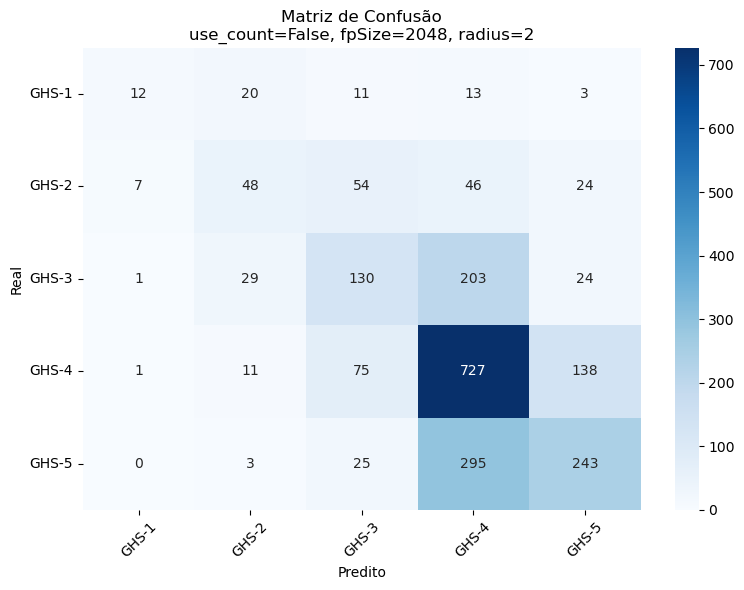

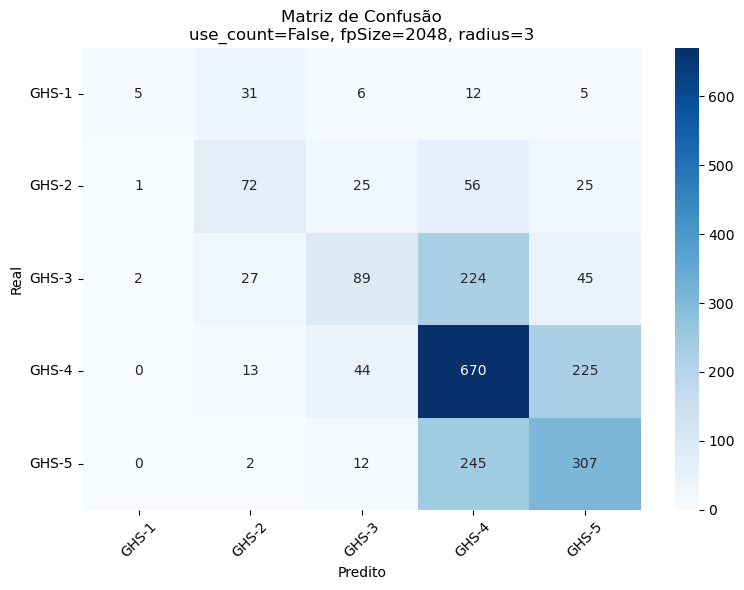

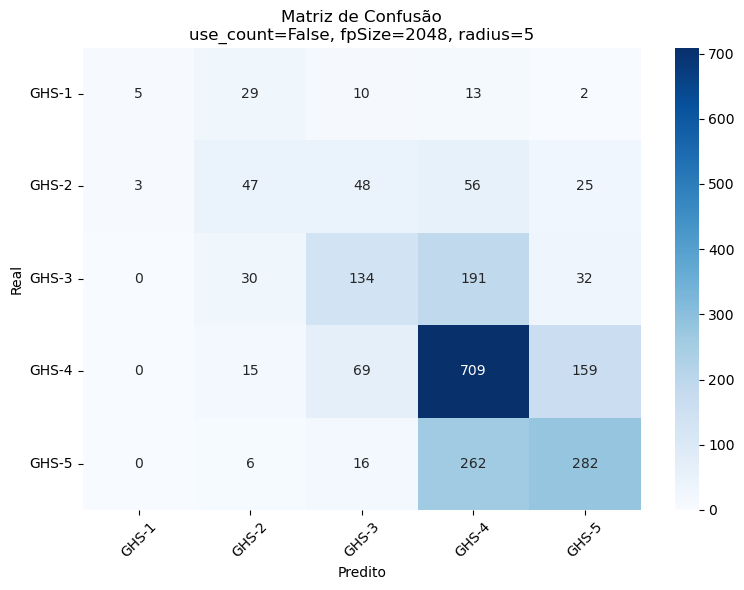

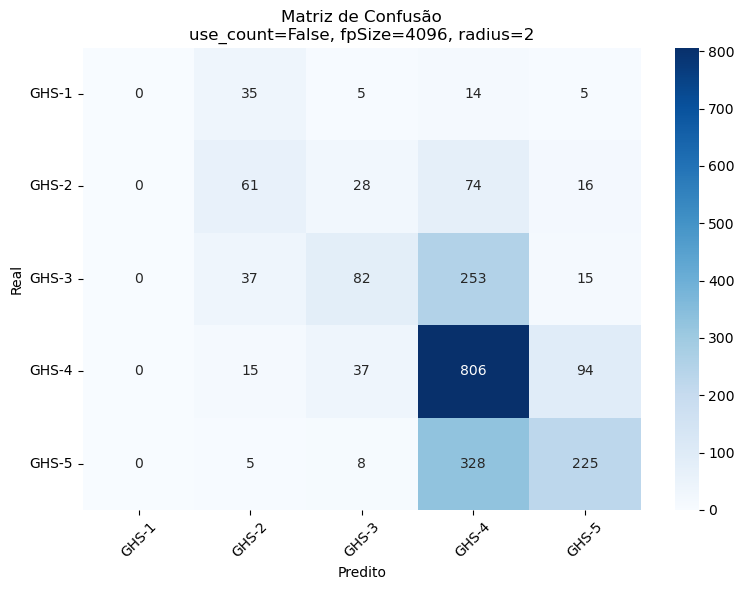

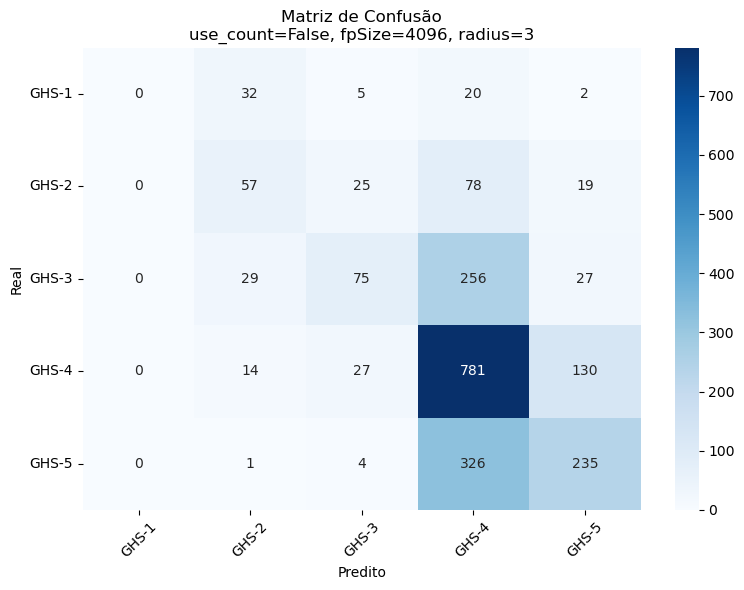

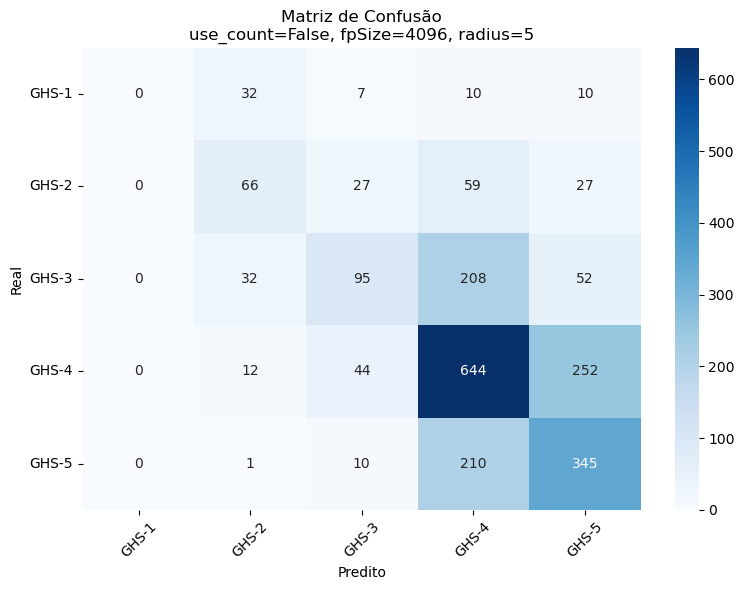

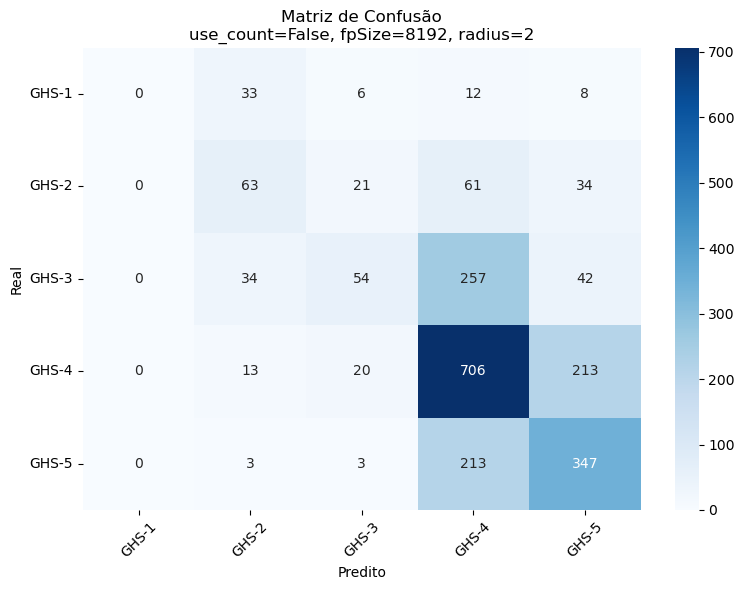

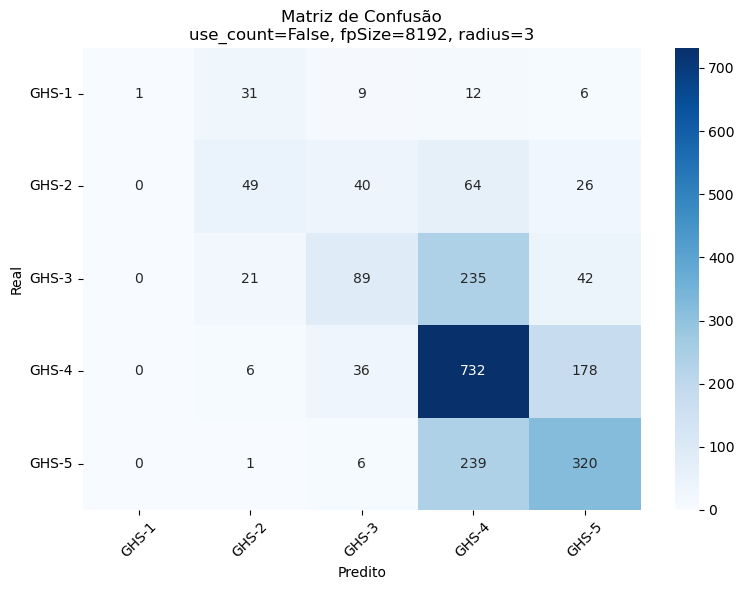

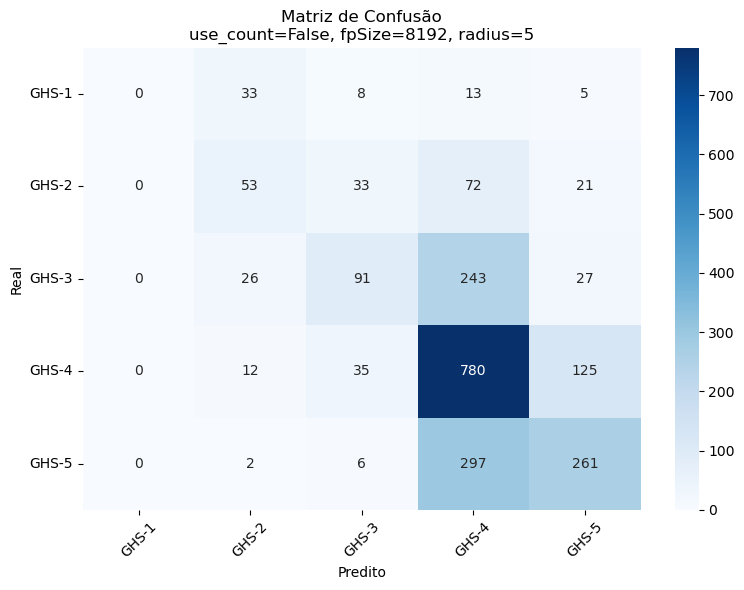

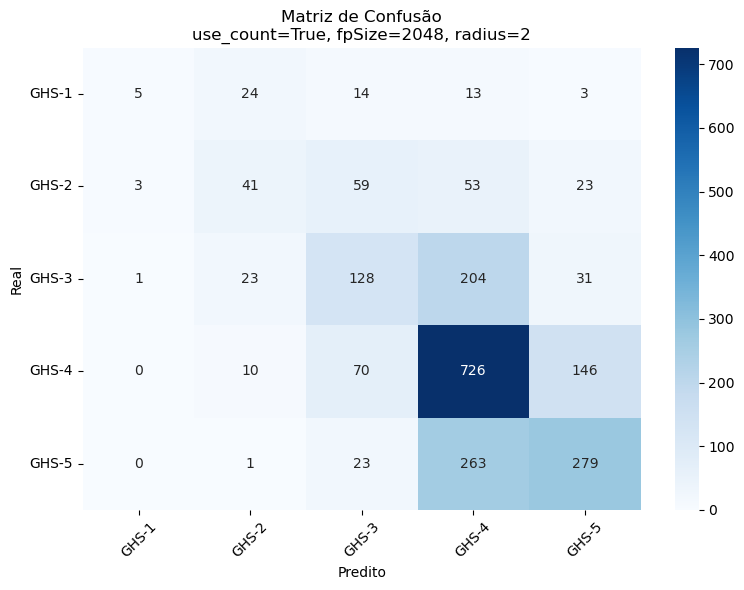

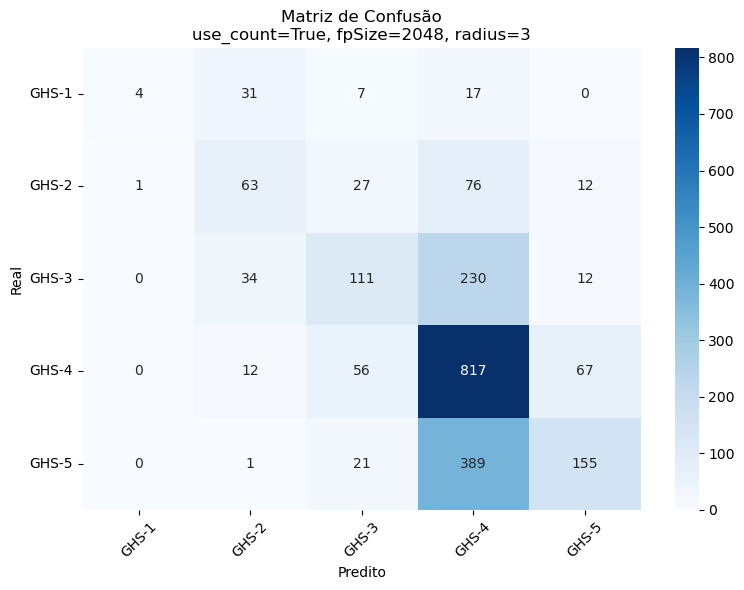

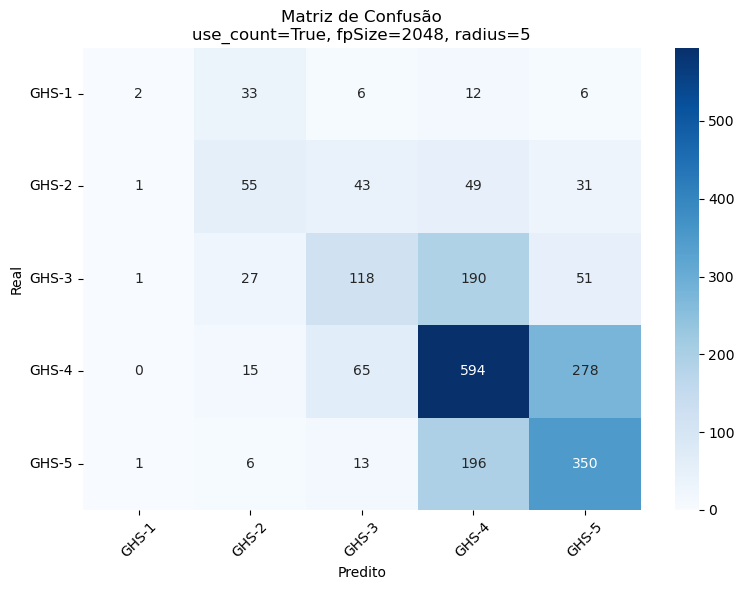

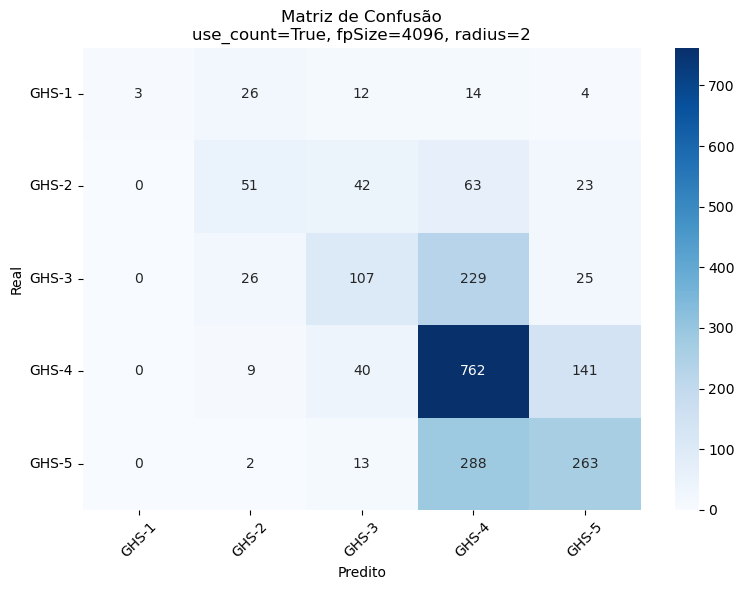

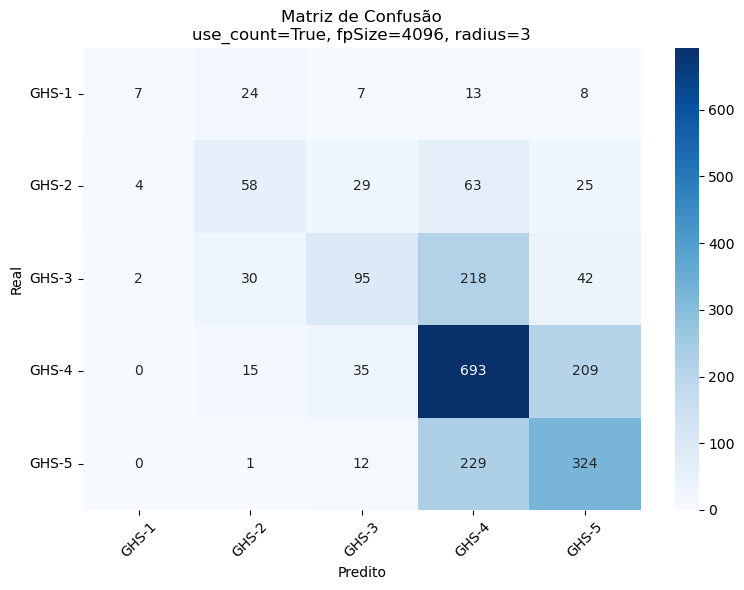

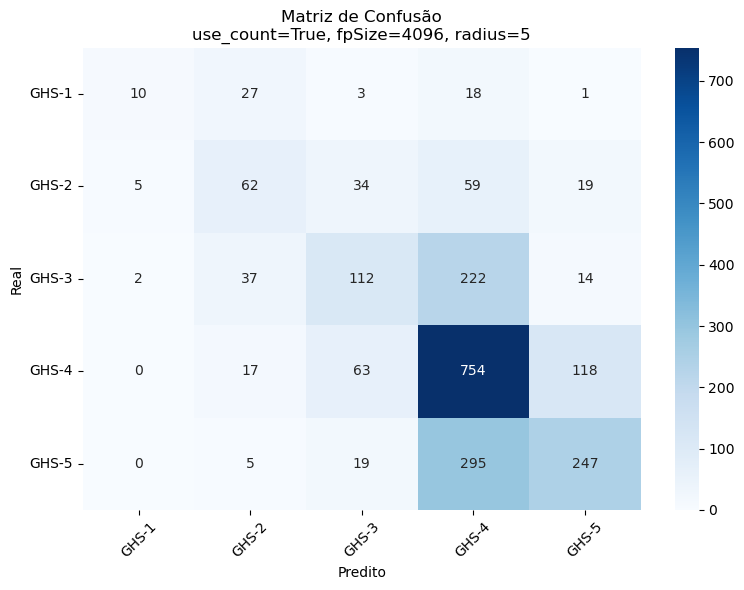

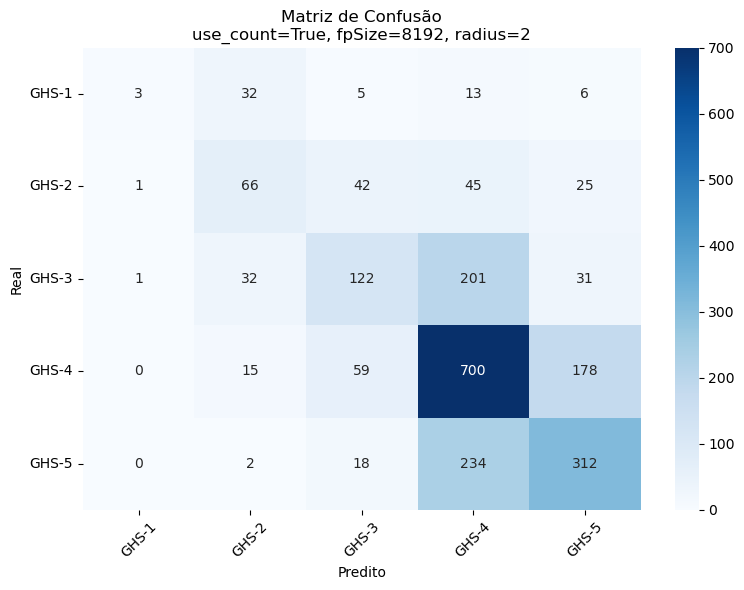

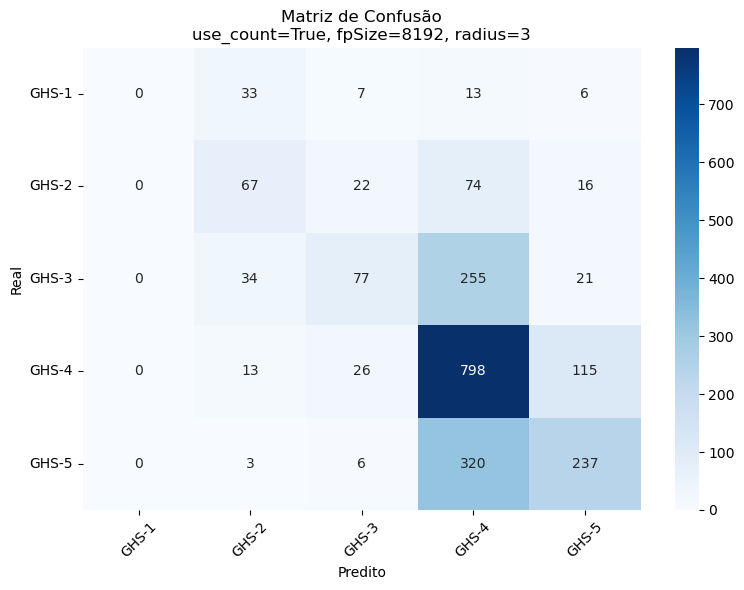

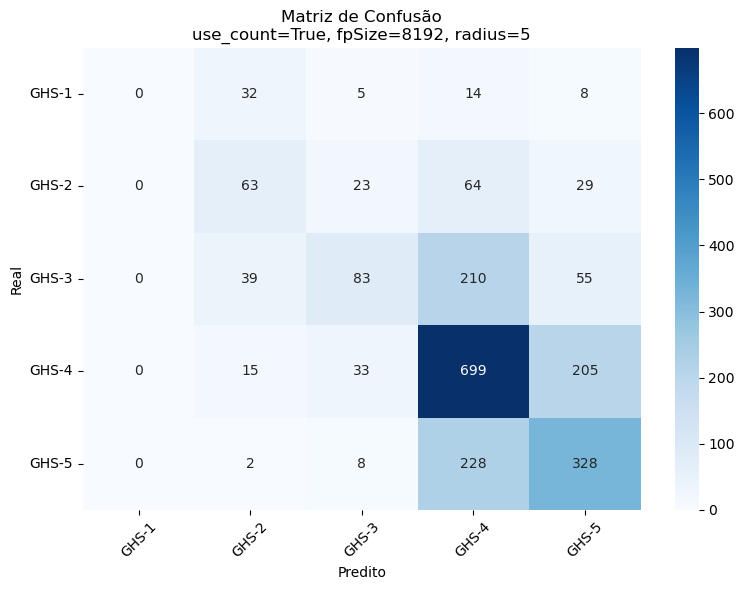


Ranking de combinações por acurácia:
    use_count  fpSize  radius  accuracy
15       True    8192       2  0.561363
7       False    8192       3  0.555763
12       True    4096       2  0.553430
14       True    4096       5  0.552963
8       False    8192       5  0.552963
9        True    2048       2  0.550163
16       True    8192       3  0.550163
2       False    2048       5  0.549230
13       True    4096       3  0.549230
3       False    4096       2  0.547830
17       True    8192       5  0.547364
6       False    8192       2  0.545964
0       False    2048       2  0.541297
10       True    2048       3  0.536631
5       False    4096       5  0.536631
4       False    4096       3  0.535698
1       False    2048       3  0.533364
11       True    2048       5  0.522165


In [ ]:
# Configurações do experimento
arquivo_classificado = "rat_vo_classificado.csv"
nome_dataset = arquivo_classificado.split("_classificado")[0]  
exibir_plot = True  

# Carregamento e pré-processamento dos dados
df = pd.read_csv(arquivo_classificado)

print("--- Mapeando categorias GHS para softmax ---")
df["GHS_Category_softmax"] = df["GHS_Category"].astype(int) - 1

classes = [f"GHS-{i+1}" for i in range(df["GHS_Category_softmax"].nunique())]

# Inicialização da lista para armazenar resultados
resultados = []

# Loop de grid
for use_count in use_count_option:
    for fpSize in fpSize_option:
        for radius in radius_option:
            print(f"\nTestando: use_count={use_count}, fpSize={fpSize}, radius={radius}")

            try: 
                # Geração de fingerprints
                rep = Representacao(df)
                df_fp = rep.fingerprint(
                    col_smiles="smiles",
                    fingerprint="morgan",
                    radius=radius,
                    fpSize=fpSize,
                    use_count=use_count
                )

                # Remove moléculas que não geraram fingerprint
                df_fp = df_fp.dropna(subset=["Features"])

                # Definição das variáveis X e y
                X = np.stack(df_fp["Features"].values)
                y = df_fp["GHS_Category_softmax"].values

                # Divisão em treino e teste
                X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

                # Construção do modelo
                model = Sequential([
                    Dense(256, activation="relu", input_shape=(X.shape[1],)),
                    Dropout(0.3),
                    Dense(128, activation="relu"),
                    Dropout(0.3),
                    Dense(len(np.unique(y)), activation="softmax")
                ])         
                model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

                # Evitar overfitting
                early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

                # Treinamento do Modelo
                model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                          callbacks=[early_stop], verbose=0)
                
                # Avaliação do modelo
                y_pred_prob = model.predict(X_test)
                y_pred_classes = np.argmax(y_pred_prob, axis=1)

                acc = accuracy_score(y_test, y_pred_classes)
                print(f"Acurácia: {acc}")

                # Salva os dados para plot posterior
                resultados.append({
                    "use_count": use_count,
                    "fpSize": fpSize,
                    "radius": radius,
                    "accuracy": acc,
                    "y_test": y_test,
                    "y_pred": y_pred_classes
                })

            except Exception as e:
                print(f"Erro em: use_count={use_count}, fpSize={fpSize}, radius={radius}")
                print(e)

# === GERAÇÃO E SALVAMENTO DOS PLOTS ===
for r in resultados:
    try:
        use_count = r["use_count"]
        fpSize = r["fpSize"]
        radius = r["radius"]
        y_true = r["y_test"]
        y_pred = r["y_pred"]

        folder_path = os.path.join("Plots", nome_dataset)
        os.makedirs(folder_path, exist_ok=True)

        file_name = f"confusion_uc-{use_count}_fp-{fpSize}_r-{radius}.png"
        file_path = os.path.join(folder_path, file_name)

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=classes, yticklabels=classes)
        plt.title(f"Matriz de Confusão\nuse_count={use_count}, fpSize={fpSize}, radius={radius}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(file_path)
        if exibir_plot:
            plt.show()
        else:
            plt.close()

    except Exception as e:
        print(f"Erro ao salvar o plot da combinação: uc={use_count}, fp={fpSize}, r={radius}")
        print(e)

# === RANKING FINAL ===
if resultados:
    resultados_df = pd.DataFrame(resultados).drop(columns=["y_test", "y_pred"])
    print("\nRanking de combinações por acurácia:")
    print(resultados_df.sort_values(by='accuracy', ascending=False).to_string())
else:
    print("\nNenhum resultado foi gerado.")

# Cria diretório de resultados, se ainda não existir
resultados_dir = os.path.join("Resultados", nome_dataset)
os.makedirs(resultados_dir, exist_ok=True)

# Caminho completo do arquivo CSV
csv_path = os.path.join(resultados_dir, "resultados.csv")

# Salva o DataFrame (sem colunas de y_test/y_pred, pois são grandes arrays)
resultados_df.to_csv(csv_path, index=False)


# Análise de toxicidade oral em camundongos

In [ ]:
# Configurações do experimento
arquivo_classificado = "mouse_vo_classificado.csv"
nome_dataset = arquivo_classificado.split("_classificado")[0]  
exibir_plot = True  

# Carregamento e pré-processamento dos dados
df = pd.read_csv(arquivo_classificado)

print("--- Mapeando categorias GHS para softmax ---")
df["GHS_Category_softmax"] = df["GHS_Category"].astype(int) - 1

classes = [f"GHS-{i+1}" for i in range(df["GHS_Category_softmax"].nunique())]

# Inicialização da lista para armazenar resultados
resultados = []

# Loop de grid
for use_count in use_count_option:
    for fpSize in fpSize_option:
        for radius in radius_option:
            print(f"\nTestando: use_count={use_count}, fpSize={fpSize}, radius={radius}")

            try: 
                # Geração de fingerprints
                rep = Representacao(df)
                df_fp = rep.fingerprint(
                    col_smiles="smiles",
                    fingerprint="morgan",
                    radius=radius,
                    fpSize=fpSize,
                    use_count=use_count
                )

                # Remove moléculas que não geraram fingerprint
                df_fp = df_fp.dropna(subset=["Features"])

                # Definição das variáveis X e y
                X = np.stack(df_fp["Features"].values)
                y = df_fp["GHS_Category_softmax"].values

                # Divisão em treino e teste
                X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

                # Construção do modelo
                model = Sequential([
                    Dense(256, activation="relu", input_shape=(X.shape[1],)),
                    Dropout(0.3),
                    Dense(128, activation="relu"),
                    Dropout(0.3),
                    Dense(len(np.unique(y)), activation="softmax")
                ])         
                model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

                # Evitar overfitting
                early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

                # Treinamento do Modelo
                model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                          callbacks=[early_stop], verbose=0)
                
                # Avaliação do modelo
                y_pred_prob = model.predict(X_test)
                y_pred_classes = np.argmax(y_pred_prob, axis=1)

                acc = accuracy_score(y_test, y_pred_classes)
                print(f"Acurácia: {acc}")

                # Salva os dados para plot posterior
                resultados.append({
                    "use_count": use_count,
                    "fpSize": fpSize,
                    "radius": radius,
                    "accuracy": acc,
                    "y_test": y_test,
                    "y_pred": y_pred_classes
                })

            except Exception as e:
                print(f"Erro em: use_count={use_count}, fpSize={fpSize}, radius={radius}")
                print(e)

# === GERAÇÃO E SALVAMENTO DOS PLOTS ===
for r in resultados:
    try:
        use_count = r["use_count"]
        fpSize = r["fpSize"]
        radius = r["radius"]
        y_true = r["y_test"]
        y_pred = r["y_pred"]

        folder_path = os.path.join("Plots", nome_dataset)
        os.makedirs(folder_path, exist_ok=True)

        file_name = f"confusion_uc-{use_count}_fp-{fpSize}_r-{radius}.png"
        file_path = os.path.join(folder_path, file_name)

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=classes, yticklabels=classes)
        plt.title(f"Matriz de Confusão\nuse_count={use_count}, fpSize={fpSize}, radius={radius}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(file_path)
        if exibir_plot:
            plt.show()
        else:
            plt.close()

    except Exception as e:
        print(f"Erro ao salvar o plot da combinação: uc={use_count}, fp={fpSize}, r={radius}")
        print(e)

# === RANKING FINAL ===
if resultados:
    resultados_df = pd.DataFrame(resultados).drop(columns=["y_test", "y_pred"])
    print("\nRanking de combinações por acurácia:")
    print(resultados_df.sort_values(by='accuracy', ascending=False).to_string())
else:
    print("\nNenhum resultado foi gerado.")

# Cria diretório de resultados, se ainda não existir
resultados_dir = os.path.join("Resultados", nome_dataset)
os.makedirs(resultados_dir, exist_ok=True)

# Caminho completo do arquivo CSV
csv_path = os.path.join(resultados_dir, "resultados.csv")

# Salva o DataFrame (sem colunas de y_test/y_pred, pois são grandes arrays)
resultados_df.to_csv(csv_path, index=False)

--- Mapeando categorias GHS para softmax ---

Testando: use_count=False, fpSize=2048, radius=2


[11:29:28] WARNING: not removing hydrogen atom without neighbors
[11:29:28] WARNING: not removing hydrogen atom without neighbors
[11:29:28] WARNING: not removing hydrogen atom without neighbors
[11:29:28] WARNING: not removing hydrogen atom without neighbors
[11:29:28] WARNING: not removing hydrogen atom without neighbors
[11:29:28] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:29:29] WARNING: not removing hydrogen atom without neighbors
[11:29:29] WARNING: not removing hydrogen atom without neighbors
[11:29:31] WARNING: not removing hydrogen atom without neighbors
[11:29:31] WARNING: not removing hydrogen atom without neighbors
[11:29:31] WARNING: not removing hydrogen atom without neighbors
[11:29:39] Unusual charge on atom 9 number of radical electrons set to zero
[11:29:39] Unusual charge on atom 4 number of radical electrons set to zero
[11:29:40] WARNING: not removing hydrogen atom without neighbors
[11:29:35] WARNING: not removing hydrogen atom without neighbors
[11:29:

160/160 [==============================] - 0s -116us/step
Acurácia: 0.690223792697291

Testando: use_count=False, fpSize=2048, radius=3


[11:30:29] WARNING: not removing hydrogen atom without neighbors
[11:30:29] WARNING: not removing hydrogen atom without neighbors
[11:30:29] WARNING: not removing hydrogen atom without neighbors
[11:30:30] WARNING: not removing hydrogen atom without neighbors
[11:30:30] WARNING: not removing hydrogen atom without neighbors
[11:30:30] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:30:30] WARNING: not removing hydrogen atom without neighbors
[11:30:30] WARNING: not removing hydrogen atom without neighbors
[11:30:31] WARNING: not removing hydrogen atom without neighbors
[11:30:31] WARNING: not removing hydrogen atom without neighbors
[11:30:31] WARNING: not removing hydrogen atom without neighbors
[11:30:33] Unusual charge on atom 9 number of radical electrons set to zero
[11:30:33] Unusual charge on atom 4 number of radical electrons set to zero
[11:30:33] WARNING: not removing hydrogen atom without neighbors
[11:30:33] WARNING: not removing hydrogen atom without neighbors
[11:30:

160/160 [==============================] - 1s 3ms/step
Acurácia: 0.6929721240675304

Testando: use_count=False, fpSize=2048, radius=5


[11:31:18] WARNING: not removing hydrogen atom without neighbors
[11:31:18] WARNING: not removing hydrogen atom without neighbors
[11:31:18] WARNING: not removing hydrogen atom without neighbors
[11:31:18] WARNING: not removing hydrogen atom without neighbors
[11:31:18] WARNING: not removing hydrogen atom without neighbors
[11:31:18] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:31:19] WARNING: not removing hydrogen atom without neighbors
[11:31:19] WARNING: not removing hydrogen atom without neighbors
[11:31:20] WARNING: not removing hydrogen atom without neighbors
[11:31:20] WARNING: not removing hydrogen atom without neighbors
[11:31:25] WARNING: not removing hydrogen atom without neighbors
[11:31:21] Unusual charge on atom 9 number of radical electrons set to zero
[11:31:21] Unusual charge on atom 4 number of radical electrons set to zero
[11:31:21] WARNING: not removing hydrogen atom without neighbors
[11:31:21] WARNING: not removing hydrogen atom without neighbors
[11:31:

160/160 [==============================] - 1s 3ms/step
Acurácia: 0.6747153513937966

Testando: use_count=False, fpSize=4096, radius=2


[11:32:05] WARNING: not removing hydrogen atom without neighbors
[11:32:05] WARNING: not removing hydrogen atom without neighbors
[11:32:05] WARNING: not removing hydrogen atom without neighbors
[11:32:10] WARNING: not removing hydrogen atom without neighbors
[11:32:10] WARNING: not removing hydrogen atom without neighbors
[11:32:10] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7
[11:32:05] WARNING: not removing hydrogen atom without neighbors
[11:32:05] WARNING: not removing hydrogen atom without neighbors
[11:32:06] WARNING: not removing hydrogen atom without neighbors
[11:32:06] WARNING: not removing hydrogen atom without neighbors
[11:32:06] WARNING: not removing hydrogen atom without neighbors
[11:32:07] Unusual charge on atom 9 number of radical electrons set to zero
[11:32:08] Unusual charge on atom 4 number of radical electrons set to zero
[11:32:08] WARNING: not removing hydrogen atom without neighbors
[11:32:08] WARNING: not removing hydrogen atom without neighbors
[11:32:

: 

# Análise de toxicidade intravenosa em camundongos

In [ ]:
# Configurações do experimento
arquivo_classificado = "mouse_vi_classificado.csv"
nome_dataset = arquivo_classificado.split("_classificado")[0]  
exibir_plot = True  

# Carregamento e pré-processamento dos dados
df = pd.read_csv(arquivo_classificado)

print("--- Mapeando categorias GHS para softmax ---")
df["GHS_Category_softmax"] = df["GHS_Category"].astype(int) - 1

classes = [f"GHS-{i+1}" for i in range(df["GHS_Category_softmax"].nunique())]

# Inicialização da lista para armazenar resultados
resultados = []

# Loop de grid
for use_count in use_count_option:
    for fpSize in fpSize_option:
        for radius in radius_option:
            print(f"\nTestando: use_count={use_count}, fpSize={fpSize}, radius={radius}")

            try: 
                # Geração de fingerprints
                rep = Representacao(df)
                df_fp = rep.fingerprint(
                    col_smiles="smiles",
                    fingerprint="morgan",
                    radius=radius,
                    fpSize=fpSize,
                    use_count=use_count
                )

                # Remove moléculas que não geraram fingerprint
                df_fp = df_fp.dropna(subset=["Features"])

                # Definição das variáveis X e y
                X = np.stack(df_fp["Features"].values)
                y = df_fp["GHS_Category_softmax"].values

                # Divisão em treino e teste
                X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

                # Construção do modelo
                model = Sequential([
                    Dense(256, activation="relu", input_shape=(X.shape[1],)),
                    Dropout(0.3),
                    Dense(128, activation="relu"),
                    Dropout(0.3),
                    Dense(len(np.unique(y)), activation="softmax")
                ])         
                model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

                # Evitar overfitting
                early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

                # Treinamento do Modelo
                model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                          callbacks=[early_stop], verbose=0)
                
                # Avaliação do modelo
                y_pred_prob = model.predict(X_test)
                y_pred_classes = np.argmax(y_pred_prob, axis=1)

                acc = accuracy_score(y_test, y_pred_classes)
                print(f"Acurácia: {acc}")

                # Salva os dados para plot posterior
                resultados.append({
                    "use_count": use_count,
                    "fpSize": fpSize,
                    "radius": radius,
                    "accuracy": acc,
                    "y_test": y_test,
                    "y_pred": y_pred_classes
                })

            except Exception as e:
                print(f"Erro em: use_count={use_count}, fpSize={fpSize}, radius={radius}")
                print(e)

# === GERAÇÃO E SALVAMENTO DOS PLOTS ===
for r in resultados:
    try:
        use_count = r["use_count"]
        fpSize = r["fpSize"]
        radius = r["radius"]
        y_true = r["y_test"]
        y_pred = r["y_pred"]

        folder_path = os.path.join("Plots", nome_dataset)
        os.makedirs(folder_path, exist_ok=True)

        file_name = f"confusion_uc-{use_count}_fp-{fpSize}_r-{radius}.png"
        file_path = os.path.join(folder_path, file_name)

        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=classes, yticklabels=classes)
        plt.title(f"Matriz de Confusão\nuse_count={use_count}, fpSize={fpSize}, radius={radius}")
        plt.xlabel("Predito")
        plt.ylabel("Real")
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.savefig(file_path)
        if exibir_plot:
            plt.show()
        else:
            plt.close()

    except Exception as e:
        print(f"Erro ao salvar o plot da combinação: uc={use_count}, fp={fpSize}, r={radius}")
        print(e)

# === RANKING FINAL ===
if resultados:
    resultados_df = pd.DataFrame(resultados).drop(columns=["y_test", "y_pred"])
    print("\nRanking de combinações por acurácia:")
    print(resultados_df.sort_values(by='accuracy', ascending=False).to_string())
else:
    print("\nNenhum resultado foi gerado.")